# 1. Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import re
import json
from datetime import datetime, timedelta
import pytz
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from ast import literal_eval
import matplotlib as mpl

# 2. Function Defined

In [2]:
# Function used to extract x & y value from activity log
def extract_x_value(point_str):
    match = re.search(r'x=(\d+)', point_str)
    if match:
        return int(match.group(1))
    return None

def extract_y_value(point_str):
    match = re.search(r'y=(\d+)', point_str)
    if match:
        return int(match.group(1))
    return None

In [3]:
def read_data_from_file(file_name):
    time_values = []
    temperature_values = []
    pressure_values = []
    altitude_values = []
    humidity_values = []
    light_values = []
    co2_values = []

    with open(file_name, 'r') as file:
        for line in file:
            # Split the line by commas
            values = line.strip().split(',')
            
            # Extract the time value and convert it to seconds
            # Input time value
            time_str = values[0]

            if time_str:
                # Current date or a specific date you want to associate with the time
                date = datetime(2023, 8, 4, 12, 30, 0)  # Year, Month, Day, Hour, Minute, Second
                date = date.date()  # You can replace this with a specific date if needed

                # Parse the input time value and create a datetime object
                time_obj = datetime.strptime(time_str, "%H:%M:%S.%f")

                # Combine the date with the time
                combined_datetime = datetime.combine(date, time_obj.time())
                time_values.append(combined_datetime)

                # Extract other values
                temperature_values.append(float(values[1]))
                pressure_values.append(float(values[2]))
                altitude_values.append(float(values[3]))
                humidity_values.append(float(values[4]))
                light_values.append(float(values[5]))
                co2_values.append(float(values[6]))

    return time_values, temperature_values, pressure_values, altitude_values, humidity_values, light_values, co2_values

In [4]:
# Define a function to parse the pupil data from the string format
def parse_pupil_data(pupil_str):
    try:
        return literal_eval(pupil_str)
    except (ValueError, SyntaxError, TypeError):
        return None

# Calculate the eye center for each row
def calculate_eye_center(row):
    left_pupil = row['Left Pupil']
    right_pupil = row['Right Pupil']
    if left_pupil is not None and right_pupil is not None:
        return ((left_pupil[0] + right_pupil[0]) // 2, (left_pupil[1] + right_pupil[1]) // 2)
    else:
        return None

In [5]:
def update_row_data(row, row_timestamp, row_a, row_w, row_s, row_d, row_left, row_right):
    if row['Input'] == "'a'":
        row_timestamp.append(row['Timestamp'])
        row_a.append(1)
        row_w.append(0)
        row_s.append(0)
        row_d.append(0)
        row_left.append(0)
        row_right.append(0)
    elif row['Input'] == "'w'":
        row_timestamp.append(row['Timestamp'])
        row_a.append(0)
        row_w.append(1)
        row_s.append(0)
        row_d.append(0)
        row_left.append(0)
        row_right.append(0)
    elif row['Input'] == "'s'":
        row_timestamp.append(row['Timestamp'])
        row_a.append(0)
        row_w.append(0)
        row_s.append(1)
        row_d.append(0)
        row_left.append(0)
        row_right.append(0)
    elif row['Input'] == "'d'":
        row_timestamp.append(row['Timestamp'])
        row_a.append(0)
        row_w.append(0)
        row_s.append(0)
        row_d.append(1)
        row_left.append(0)
        row_right.append(0)
    elif row['Input'] == "Button.left":
        row_timestamp.append(row['Timestamp'])
        row_a.append(0)
        row_w.append(0)
        row_s.append(0)
        row_d.append(0)
        row_left.append(1)
        row_right.append(0)
    elif row['Input'] == "Button.right":
        row_timestamp.append(row['Timestamp'])
        row_a.append(0)
        row_w.append(0)
        row_s.append(0)
        row_d.append(0)
        row_left.append(0)
        row_right.append(1)

def plot_logger(axs, count, row_timestamp, row_a, row_w, row_s, row_d, row_left, row_right):
    non_zero_indices = [i for i, value in enumerate(row_a) if value != 0]
    row_timestamp_a = [row_timestamp[i] - row_timestamp[non_zero_indices[0]] + 1 for i in non_zero_indices]
    row_a = [row_a[i] for i in non_zero_indices]
    axs[count].scatter(row_timestamp_a, row_a, label="'a'")
    
    non_zero_indices = [i for i, value in enumerate(row_w) if value != 0]
    row_timestamp_w = [row_timestamp[i] - row_timestamp[non_zero_indices[0]] + 1 for i in non_zero_indices]
    row_w = [row_w[i] for i in non_zero_indices]
    axs[count].scatter(row_timestamp_w, row_w, label="'w'")
    
    non_zero_indices = [i for i, value in enumerate(row_d) if value != 0]
    row_timestamp_d = [row_timestamp[i] - row_timestamp[non_zero_indices[0]] + 1 for i in non_zero_indices]
    row_d = [row_d[i] for i in non_zero_indices]
    axs[count].scatter(row_timestamp_d, row_d, label="'d'")
    
    non_zero_indices = [i for i, value in enumerate(row_s) if value != 0]
    row_timestamp_s = [row_timestamp[i] - row_timestamp[non_zero_indices[0]] + 1 for i in non_zero_indices]
    row_s = [row_s[i] for i in non_zero_indices]
    axs[count].scatter(row_timestamp_s, row_s, label="'s'")
    
    non_zero_indices = [i for i, value in enumerate(row_left) if value != 0]
    row_timestamp_left = [row_timestamp[i] - row_timestamp[non_zero_indices[0]] + 1 for i in non_zero_indices]
    row_left = [row_left[i] for i in non_zero_indices]
    axs[count].scatter(row_timestamp_left, row_left, label="'left'")
    
    non_zero_indices = [i for i, value in enumerate(row_right) if value != 0]
    row_timestamp_right = [row_timestamp[i] - row_timestamp[non_zero_indices[0]] + 1 for i in non_zero_indices]
    row_right= [row_right[i] for i in non_zero_indices]
    axs[count].scatter(row_timestamp_right, row_right, label="'right'")

# 3. Data Input & Preprocessing

In [6]:
#Readin emotion data and do pre-processing
emotion = pd.read_csv("emotion_data.csv")
emotion['Timestamp'] = emotion.Timestamp.apply(lambda x: datetime.fromtimestamp(x).strftime('%m/%d/%Y %H:%M:%S.%f'))

In [7]:
# Readin keyboard activity data and do pre-processing
keyboard = pd.read_csv('activity_log.csv')
keyboard['Timestamp'] = pd.to_datetime(keyboard['Timestamp'], format='%d/%m/%Y, %H:%M:%S.%f')
keyboard['X_Value'] = keyboard['Mouse Position'].apply(extract_x_value)
keyboard['Y_Value'] = keyboard['Mouse Position'].apply(extract_y_value)

In [8]:
# Readin EEG data and do pre-processing
eeg = pd.read_csv("EEG_recording_2023-08-04-19.25.21.csv")
eeg['timestamps_alt'] = eeg.timestamps.apply(lambda x: datetime.fromtimestamp(x).strftime('%m/%d/%Y %H:%M:%S.%f')[:-3])

In [9]:
# Read Gaze data and do pre-processing
gaze = pd.read_csv('gaze_data.csv')
# Convert the 'Timestamp' column to pandas datetime format with the appropriate format specified
gaze['Timestamp'] = pd.to_datetime(gaze['Timestamp'], unit='s')
# Apply the parsing function to 'Left Pupil' and 'Right Pupil' columns
gaze['Left Pupil'] = gaze['Left Pupil'].apply(parse_pupil_data)
gaze['Right Pupil'] = gaze['Right Pupil'].apply(parse_pupil_data)
gaze['Eye Center'] = gaze.apply(calculate_eye_center, axis=1)

In [10]:
# Readin posture data
posture = pd.read_csv("posture_changes.csv")

In [11]:
# Read environmental data and do pre-processing
file_name = 'env_data.txt'
time_values, temperature_values, pressure_values, altitude_values, humidity_values, light_values, co2_values = read_data_from_file(file_name)
time_series = pd.Series(time_values)

# Convert to pandas datetime
time_series = pd.to_datetime(time_series)

# Subtract the minimum value from each element and calculate the total seconds
time_values_in_seconds = (time_series - time_series.min()).dt.total_seconds()

In [12]:
# Read IMU data and do pre-processing
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['r', 'b', 'y'])

times = []
l1_g_data = []
l1_a_data = []
r1_g_data = []
r1_a_data = []
l2_g_data = []
l2_a_data = []
r2_g_data = []
r2_a_data = []
l3_g_data = []
l3_a_data = []
r3_g_data = []
r3_a_data = []

with open("imu_data.txt", 'r') as file:
    data = file.readlines()
    for i in data:
        temp = i.strip().split(",")
        tempfloat = []
        for j in range(len(temp)):
            if j == 0:
                time_str = temp[j]

                date = datetime(2023, 8, 4, 12, 30, 0)  #Change the date if data.json change
                date = date.date()

                time_obj = datetime.strptime(time_str, "%H:%M:%S.%f")

                # Combine the date with the time
                combined_datetime = datetime.combine(date, time_obj.time())
                times.append(combined_datetime)
            elif ((j % 6)-1) > 3:
                if(float(temp[j]) > 40):
                    tempfloat.append(40)
                elif(float(temp[j]) < -40):
                    tempfloat.append(-40)
                else:
                    tempfloat.append(float(temp[j]))
            else:
                if(float(temp[j]) > 34.9):
                    tempfloat.append(34.91)
                elif(float(temp[j]) < -34.9):
                    tempfloat.append(-34.91)
                else:
                    tempfloat.append(float(temp[j]))

        l1_g_data.append(tempfloat[0:3])
        l1_a_data.append(tempfloat[3:6])
        r1_g_data.append(tempfloat[6:9])
        r1_a_data.append(tempfloat[9:12])
        l2_g_data.append(tempfloat[12:15])
        l2_a_data.append(tempfloat[15:18])
        r2_g_data.append(tempfloat[18:21])
        r2_a_data.append(tempfloat[21:24])
        l3_g_data.append(tempfloat[24:27])
        l3_a_data.append(tempfloat[27:30])
        r3_g_data.append(tempfloat[30:33])
        r3_a_data.append(tempfloat[33:])
time_series2 = pd.Series(times)

# Convert to pandas datetime
time_series2 = pd.to_datetime(time_series2)

# Subtract the minimum value from each element and calculate the total seconds
time_values_in_seconds2 = (time_series2 - time_series2.min()).dt.total_seconds()

In [13]:
# Read in-game data from JSON file
with open('data.json', 'r') as f:
    data_dict = json.load(f)

timestamps = []
kills = []
death = []

# Process the JSON data and extract the relevant information
for timestamp, values in data_dict.items():
    temp_time = pd.to_datetime(float(timestamp), unit='s')
    timestamps.append(temp_time)  # Convert the timestamp to pandas datetime
    kills.append(values['player_kill_other'])
    death.append(values['player_get_killed'])

kill_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Kills': kills
})
death_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Death': death
})


In [14]:
pittsburgh_tz = pytz.timezone('US/Eastern')
kill_df['Timestamp'] = kill_df['Timestamp'].apply(lambda x: pd.Timestamp(x, unit='s', tz='UTC').tz_convert(pittsburgh_tz))
death_df['Timestamp'] = death_df['Timestamp'].apply(lambda x: pd.Timestamp(x, unit='s', tz='UTC').tz_convert(pittsburgh_tz))
gaze['Timestamp'] = gaze['Timestamp'].apply(lambda x: pd.Timestamp(x, unit='s', tz='UTC').tz_convert(pittsburgh_tz))
# for timestamp in gaze['Timestamp']:
#     timestamp_utc = timestamp.tz_convert('UTC')

#     # Calculate the difference from the Unix epoch (1970-01-01) in seconds
#     time_diff = timestamp_utc - pd.Timestamp('1970-01-01', tz='UTC')

#     # Get the total seconds as a float
#     seconds_float = time_diff.total_seconds()
#     gaze['timestamp_new'] = seconds_float

# 4. Visualize the Data

In [15]:
kill_df

,Timestamp,Kills
0,2023-08-04 15:25:39.676266496-04:00,0
1,2023-08-04 15:25:43.118897920-04:00,0
2,2023-08-04 15:25:43.208710144-04:00,0
3,2023-08-04 15:25:43.292010240-04:00,0
4,2023-08-04 15:25:43.371627776-04:00,0
...,...,...
5995,2023-08-04 15:33:12.241606400-04:00,0
5996,2023-08-04 15:33:12.333537536-04:00,0
5997,2023-08-04 15:33:12.411531264-04:00,0
5998,2023-08-04 15:33:12.492659456-04:00,0


In [16]:
eeg

,timestamps,TP9,AF7,AF8,TP10,Right AUX,timestamps_alt
0,1.691177e+09,-26.855,-265.625,-36.621,-23.438,0.0,08/04/2023 15:25:26.707
1,1.691177e+09,-10.742,288.086,-40.527,-4.883,0.0,08/04/2023 15:25:26.710
2,1.691177e+09,-10.254,-695.801,-42.969,-28.809,0.0,08/04/2023 15:25:26.714
3,1.691177e+09,-46.875,-1000.000,-44.434,-48.340,0.0,08/04/2023 15:25:26.718
4,1.691177e+09,-45.898,-574.707,-39.551,-29.785,0.0,08/04/2023 15:25:26.722
...,...,...,...,...,...,...,...
114283,1.691178e+09,-17.578,-197.754,-42.480,-41.504,0.0,08/04/2023 15:32:53.095
114284,1.691178e+09,-12.207,64.453,-34.180,-4.883,0.0,08/04/2023 15:32:53.099
114285,1.691178e+09,-11.230,204.590,-34.668,5.371,0.0,08/04/2023 15:32:53.103
114286,1.691178e+09,-41.016,-170.898,-38.086,-22.461,0.0,08/04/2023 15:32:53.107


In [17]:
posture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243 entries, 0 to 2242
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                2243 non-null   object 
 1   X Coordinate Difference  2243 non-null   float64
 2   Y Coordinate Difference  2243 non-null   float64
dtypes: float64(2), object(1)
memory usage: 52.7+ KB


# 5. Process Timestamps as seconds difference

In [18]:
# Convert the Timestamp column of the kill and death DataFrame to numeric values in seconds
kill_df['Timestamp'] = (kill_df['Timestamp'] - kill_df['Timestamp'].min()).dt.total_seconds()
death_df['Timestamp'] = (death_df['Timestamp'] - death_df['Timestamp'].min()).dt.total_seconds()
# Convert the Timestamp column of the emotion DataFrame to numeric values in seconds
if isinstance(emotion['Timestamp'].iloc[0], str):
    emotion['Timestamp'] = pd.to_datetime(emotion['Timestamp'])
emotion['Timestamp'] = (emotion['Timestamp'] - emotion['Timestamp'].min()).dt.total_seconds()
if isinstance(eeg['timestamps_alt'].iloc[0], str):
    eeg['timestamps_alt'] = pd.to_datetime(eeg['timestamps_alt'])
eeg['timestamps_alt'] = (eeg['timestamps_alt'] - eeg['timestamps_alt'].min()).dt.total_seconds()
keyboard['Timestamp'] = (keyboard['Timestamp'] - keyboard['Timestamp'].min()).dt.total_seconds()
gaze['Timestamp'] = (gaze['Timestamp'] - gaze['Timestamp'].min()).dt.total_seconds()
if isinstance(posture['Timestamp'].iloc[0], str):
    posture['Timestamp'] = pd.to_datetime(posture['Timestamp'])
posture['Timestamp'] = (posture['Timestamp'] - posture['Timestamp'].min()).dt.total_seconds()

In [19]:
posture

,Timestamp,X Coordinate Difference,Y Coordinate Difference
0,0.000000,-0.000541,0.007380
1,0.034876,-0.001280,0.005115
2,0.075178,-0.000885,0.002783
3,0.109169,-0.001575,0.001007
4,0.368260,0.001749,-0.000853
...,...,...,...
2238,488.513983,0.000579,0.001476
2239,488.614259,0.003194,0.000842
2240,488.808917,0.000833,0.000557
2241,488.889541,0.000501,0.001760


In [20]:
kill_timestamps = []
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        kill_timestamps.append(timestamp)

In [21]:
death_timestamps = []
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        death_timestamps.append(timestamp)

# 6. Plot seperate components against kills and death

## 6.1 EEG vs Kills

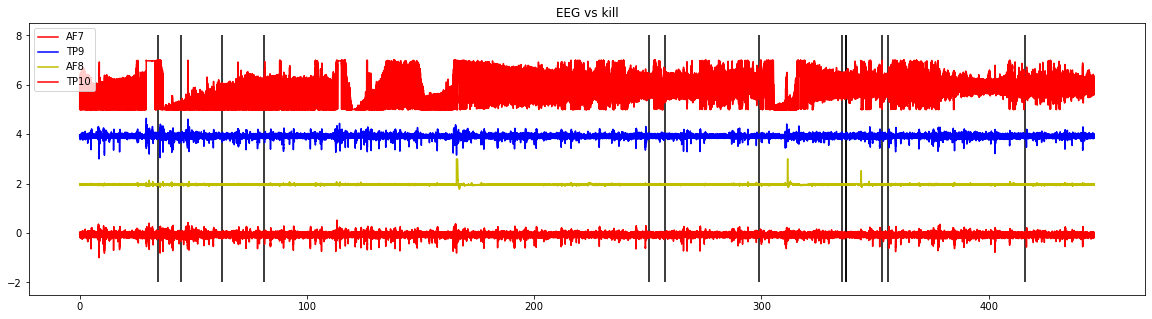

In [22]:
# EEG against kill
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
plt.figure(figsize = (20,5)) 
plt.plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label = 'AF7')
plt.plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label = 'TP9')
plt.plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label = 'AF8')
plt.plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label = 'TP10')
# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        plt.vlines(timestamp, -2, 8, colors='black')
plt.title("EEG vs kill")
plt.legend()
plt.show()

## 6.2 EEG vs Death

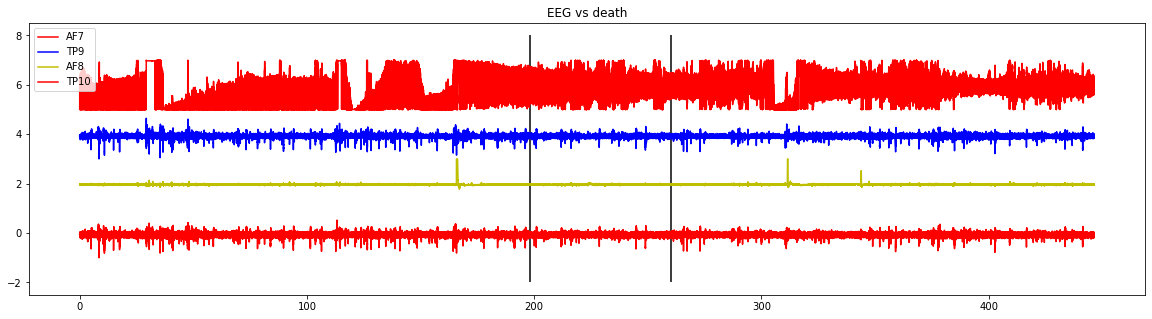

In [23]:
# EEG against death
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
plt.figure(figsize = (20,5)) 
plt.plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label = 'AF7')
plt.plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label = 'TP9')
plt.plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label = 'AF8')
plt.plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label = 'TP10')
# Plot vertical lines for kills
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        plt.vlines(timestamp, -2, 8, colors='black')
plt.title("EEG vs death")
plt.legend()
plt.show()

## 6.3 Emotion vs Kills

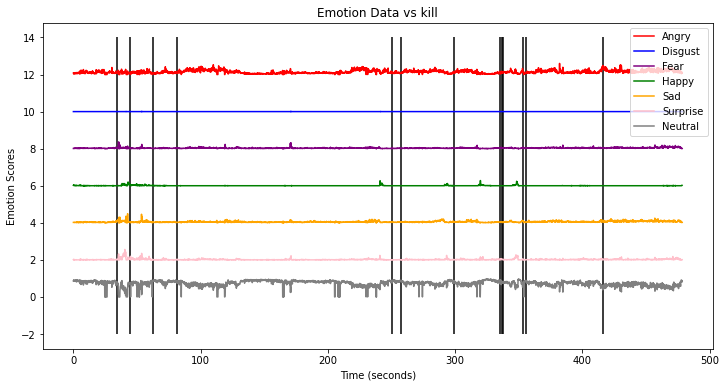

In [24]:
# Plot Emotion data against kill
plt.figure(figsize=(12, 6))
plt.plot(emotion['Timestamp'], emotion['Angry']+12, label='Angry', color='red')
plt.plot(emotion['Timestamp'], emotion['Disgust']+10, label='Disgust', color='blue')
plt.plot(emotion['Timestamp'], emotion['Fear']+8, label='Fear', color='purple')
plt.plot(emotion['Timestamp'], emotion['Happy']+6, label='Happy', color='green')
plt.plot(emotion['Timestamp'], emotion['Sad']+4, label='Sad', color='orange')
plt.plot(emotion['Timestamp'], emotion['Surprise']+2, label='Surprise', color='pink')
plt.plot(emotion['Timestamp'], emotion['Neutral'], label='Neutral', color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Emotion Scores', color='black')
plt.title('Emotion Data vs kill')
plt.legend(loc='upper right')

# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        plt.vlines(timestamp, -2, 14, colors='black')

plt.show()
plt.close()

## 6.4 Emotion vs Death

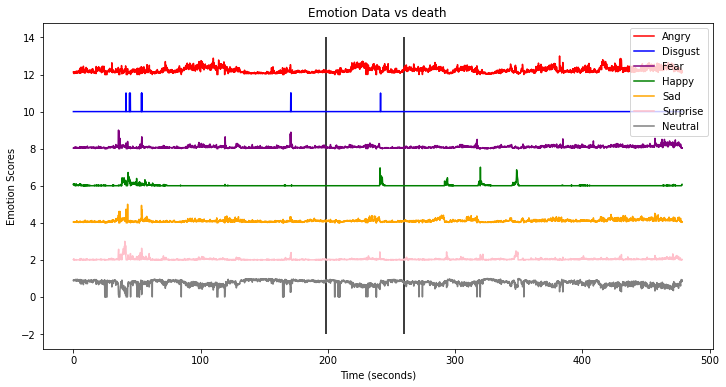

In [25]:
# Plot Emotion data against death
plt.figure(figsize=(12, 6))
plt.plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
plt.plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
plt.plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
plt.plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
plt.plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
plt.plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
plt.plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Emotion Scores', color='black')
plt.title('Emotion Data vs death')
plt.legend(loc='upper right')

# Plot vertical lines for kills
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        plt.vlines(timestamp, -2, 14, colors='black')

plt.show()
plt.close()

## 6.5 Keyboard logger vs Kills

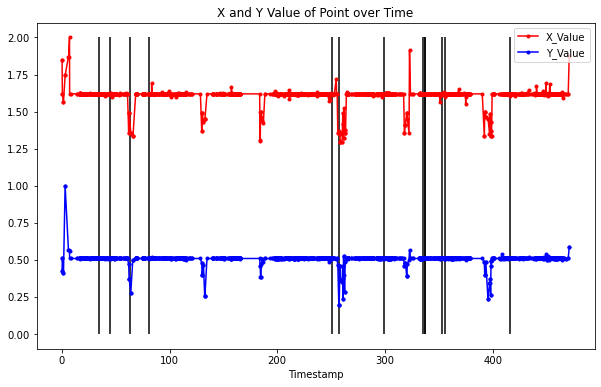

In [26]:
# Plot activity data against kill
plt.figure(figsize=(10, 6))
plt.plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
plt.plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')

# Customize the plot
plt.xlabel('Timestamp')
plt.title('X and Y Value of Point over Time')

#date_form = mdates.DateFormatter("%H:%M:%S")
#plt.gca().xaxis.set_major_formatter(date_form)

# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        plt.vlines(timestamp, 0, 2, colors='black')

plt.legend(loc='upper right')

# Display the plot
plt.show()
plt.close()

## 6.6 Keyboard logger vs Death

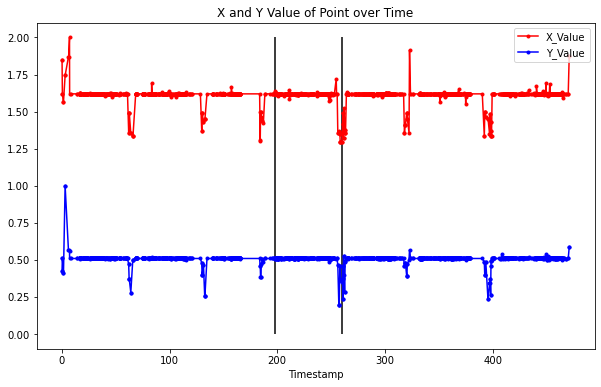

In [27]:
# Plot activity data against death
plt.figure(figsize=(10, 6))
plt.plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
plt.plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')

# Customize the plot
plt.xlabel('Timestamp')
plt.title('X and Y Value of Point over Time')

#date_form = mdates.DateFormatter("%H:%M:%S")
#plt.gca().xaxis.set_major_formatter(date_form)

# Plot vertical lines for kills
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        plt.vlines(timestamp, 0, 2, colors='black')

plt.legend(loc='upper right')

# Display the plot
plt.show()
plt.close()

## 6.7 Posture vs Kill

In [28]:
posture.columns

Index(['Timestamp', 'X Coordinate Difference', 'Y Coordinate Difference'], dtype='object')

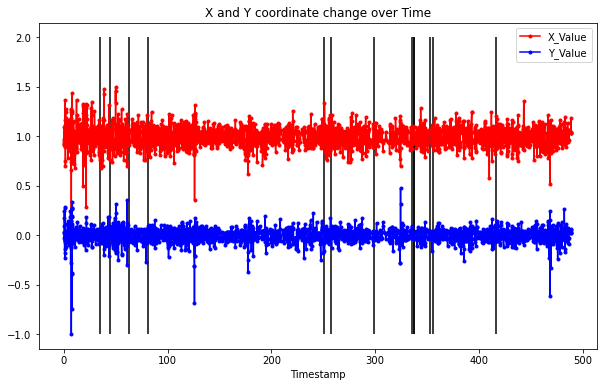

In [29]:
# Plot activity data against kill
plt.figure(figsize=(10, 6))
plt.plot(posture['Timestamp'], posture['X Coordinate Difference']/max(abs(posture['X Coordinate Difference']))+1, marker='.', linestyle='-', color='red', label='X_Value')
plt.plot(posture['Timestamp'], posture['Y Coordinate Difference']/max(abs(posture['Y Coordinate Difference'])), marker='.', linestyle='-', color='blue', label='Y_Value')

# Customize the plot
plt.xlabel('Timestamp')
plt.title('X and Y coordinate change over Time')

# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        plt.vlines(timestamp, -1, 2, colors='black')

plt.legend(loc='upper right')

# Display the plot
plt.show()
plt.close()

## 6.8 Posture vs Death

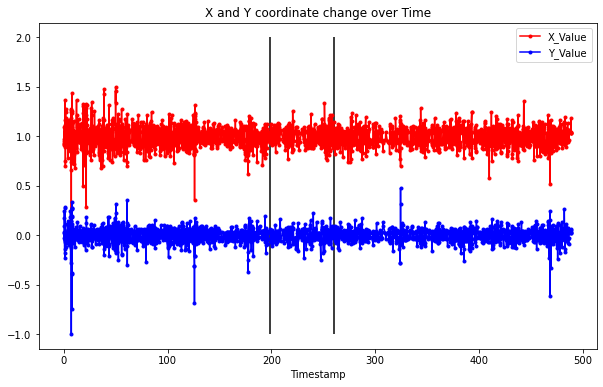

In [30]:
# Plot activity data against kill
plt.figure(figsize=(10, 6))
plt.plot(posture['Timestamp'], posture['X Coordinate Difference']/max(abs(posture['X Coordinate Difference']))+1, marker='.', linestyle='-', color='red', label='X_Value')
plt.plot(posture['Timestamp'], posture['Y Coordinate Difference']/max(abs(posture['Y Coordinate Difference'])), marker='.', linestyle='-', color='blue', label='Y_Value')

# Customize the plot
plt.xlabel('Timestamp')
plt.title('X and Y coordinate change over Time')

# Plot vertical lines for death
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        plt.vlines(timestamp, -1, 2, colors='black')

plt.legend(loc='upper right')

# Display the plot
plt.show()
plt.close()

# 7. Overall Graph

## 7.1 Overall Kill Graph (Except IMU)

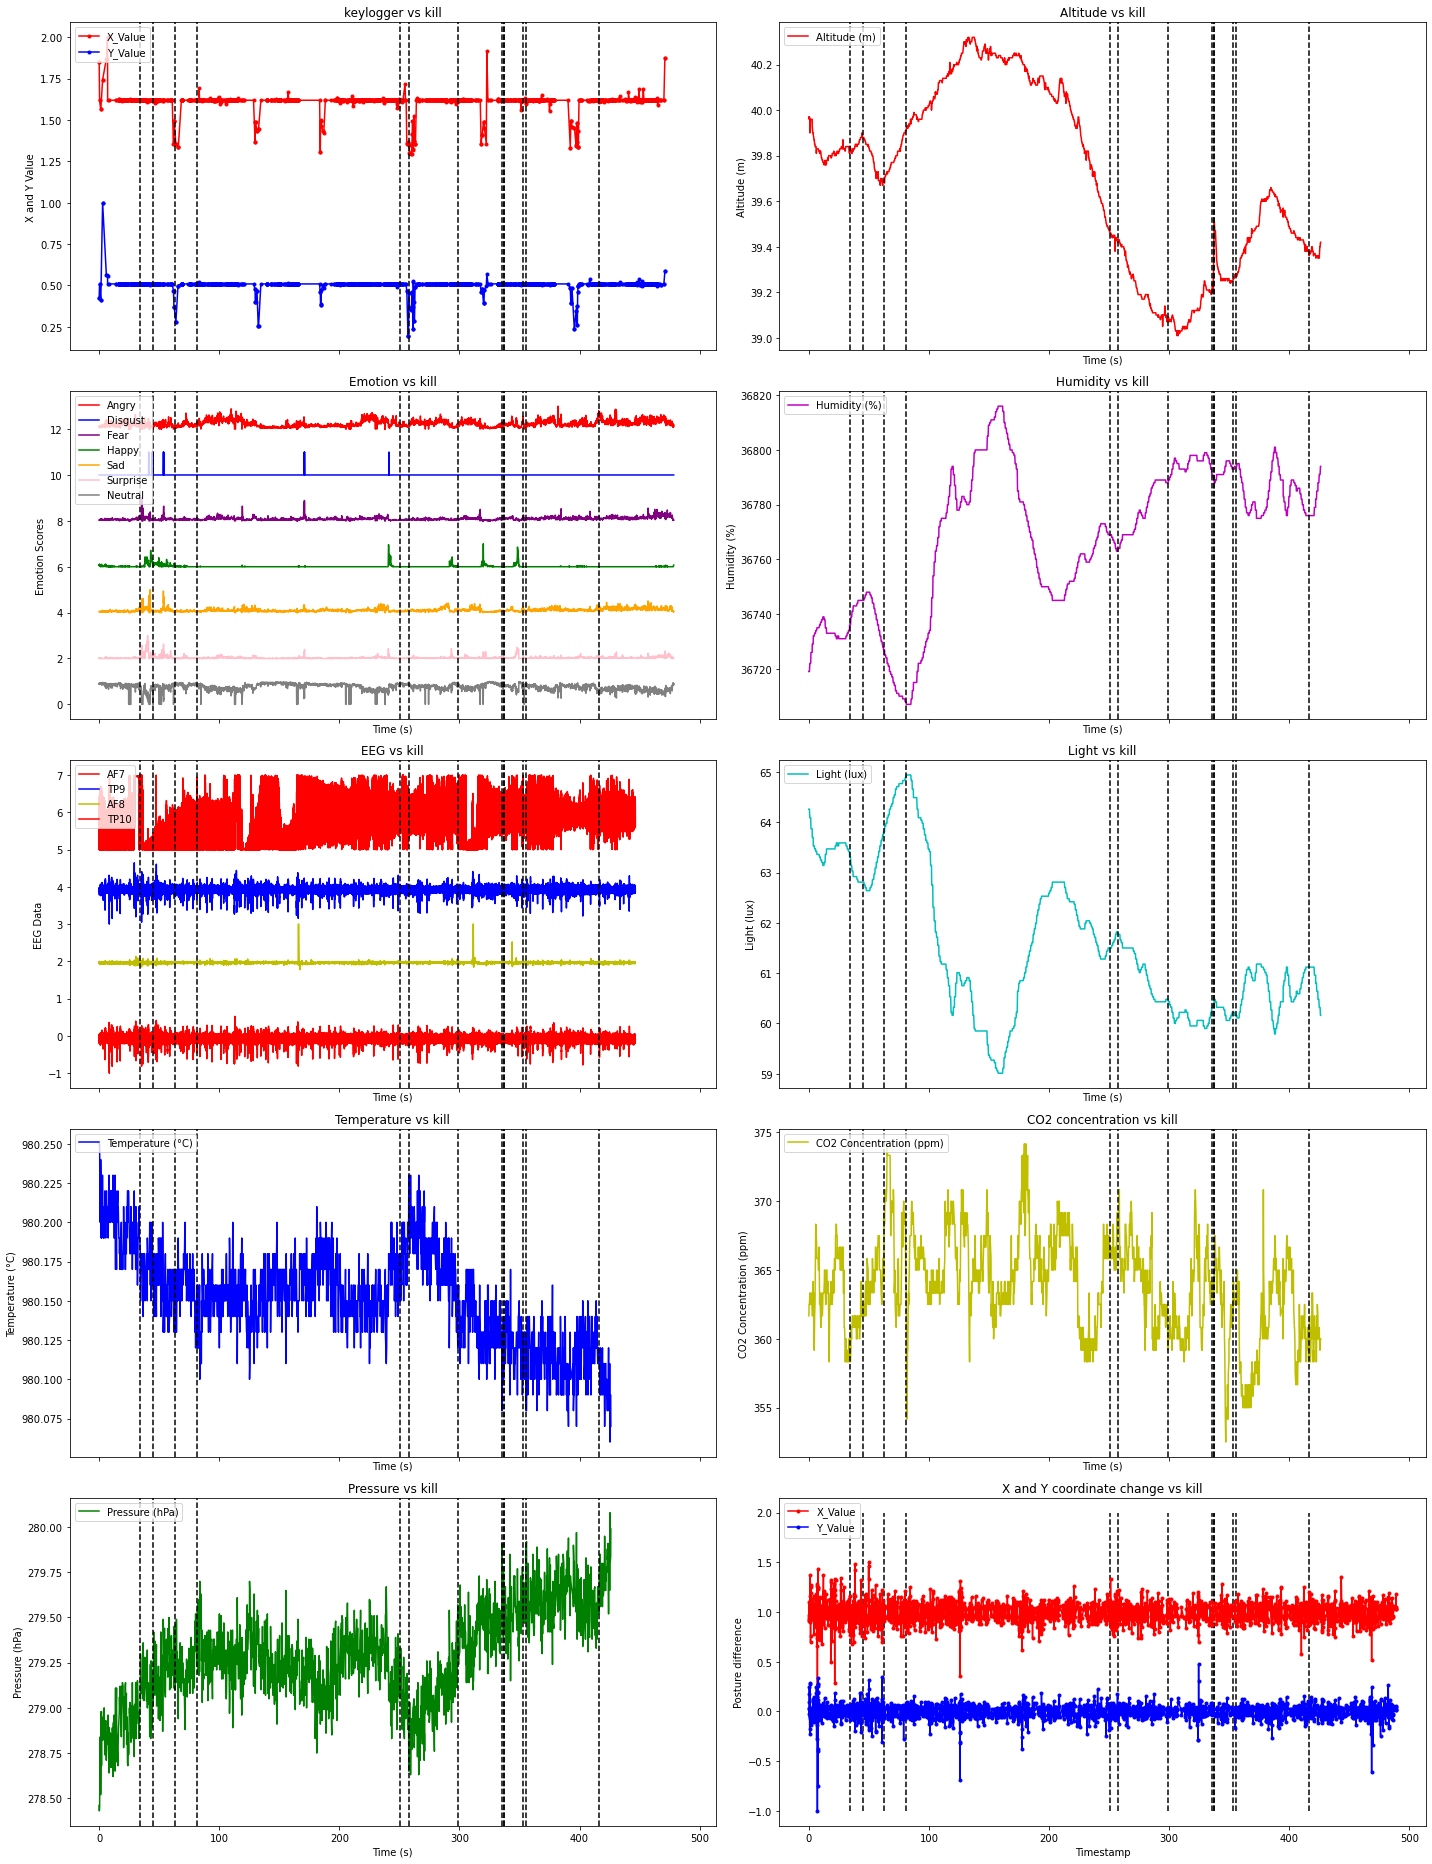

In [31]:
# Overall against kill
# Create a figure with two subplots sharing the x-axis
fig, axs = plt.subplots(5, 2, figsize=(20, 26), sharex=True)

# Plot activity data against kill on the first subplot
axs[0,0].plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[0,0].plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')
axs[1,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('X and Y Value', color='black')
axs[0,0].legend(loc='upper left')
axs[0,0].set_title('keylogger vs kill')

# Plot vertical lines for kills on the first subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,0].axvline(timestamp, 0, 2, color='black',linestyle='--')

# Plot Emotion data against kills on the second subplot
axs[1,0].plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
axs[1,0].plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
axs[1,0].plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
axs[1,0].plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
axs[1,0].plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
axs[1,0].plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
axs[1,0].plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Emotion Scores', color='black')
axs[1,0].legend(loc='upper left')
axs[1,0].set_title("Emotion vs kill")

# Plot vertical lines for kills on the second subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,0].axvline(timestamp, 0, 2, color='black',linestyle='--')

# EEG against kills on the third subplot
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
axs[2,0].plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label='AF7')
axs[2,0].plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label='TP9')
axs[2,0].plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label='AF8')
axs[2,0].plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label='TP10')
axs[2,0].set_xlabel('Time (s)')
axs[2,0].set_ylabel('EEG Data', color='black')
axs[2,0].legend(loc='upper left')
axs[2,0].set_title("EEG vs kill")

# Plot vertical lines for kills on the third subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,0].axvline(timestamp, 0, 2, color='black',linestyle='--')

# Temperature against kills on the forth subplot
axs[3, 0].plot(time_values_in_seconds, temperature_values, 'b-', label='Temperature (°C)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,0].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Temperature (°C)')
axs[3, 0].legend(loc='upper left')
axs[3, 0].set_title("Temperature vs kill")

# Pressure against kills on the fifth subplot
axs[4, 0].plot(time_values_in_seconds, pressure_values, 'g-', label='Pressure (hPa)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[4,0].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Pressure (hPa)')
axs[4, 0].legend(loc='upper left')
axs[4, 0].set_title("Pressure vs kill")

# Altitude against kills on the sixth subplot
axs[0, 1].plot(time_values_in_seconds, altitude_values, 'r-', label='Altitude (m)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Altitude (m)')
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title("Altitude vs kill")

# Humidity against kills on the seventh subplot
axs[1, 1].plot(time_values_in_seconds, humidity_values, 'm-', label='Humidity (%)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Humidity (%)')
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_title("Humidity vs kill")

# Light against kills on the eighth subplot
axs[2, 1].plot(time_values_in_seconds, light_values, 'c-', label='Light (lux)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Light (lux)')
axs[2, 1].legend(loc='upper left')
axs[2, 1].set_title("Light vs kill")

# CO2 concentration against kills on the nineth subplot
axs[3, 1].plot(time_values_in_seconds, co2_values, 'y-', label='CO2 Concentration (ppm)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('CO2 Concentration (ppm)')
axs[3, 1].legend(loc='upper left')
axs[3, 1].set_title("CO2 concentration vs kill")


# Posture change against kills on the tenth subplot
axs[4, 1].plot(posture['Timestamp'], posture['X Coordinate Difference']/max(abs(posture['X Coordinate Difference']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[4, 1].plot(posture['Timestamp'], posture['Y Coordinate Difference']/max(abs(posture['Y Coordinate Difference'])), marker='.', linestyle='-', color='blue', label='Y_Value')
# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[4, 1].vlines(timestamp, -1, 2, colors='black',linestyle='--')
# Customize the plot
axs[4, 1].set_xlabel('Timestamp')
axs[4, 1].set_ylabel('Posture difference')
axs[4, 1].legend(loc='upper left')
axs[4, 1].set_title('X and Y coordinate change vs kill')

# Adjust layout and display the plot
fig.tight_layout()
fig.savefig("Overal kill Graph.png")
plt.show()
plt.close(fig)

##  7.2 Overall Death Graph (Except IMU)

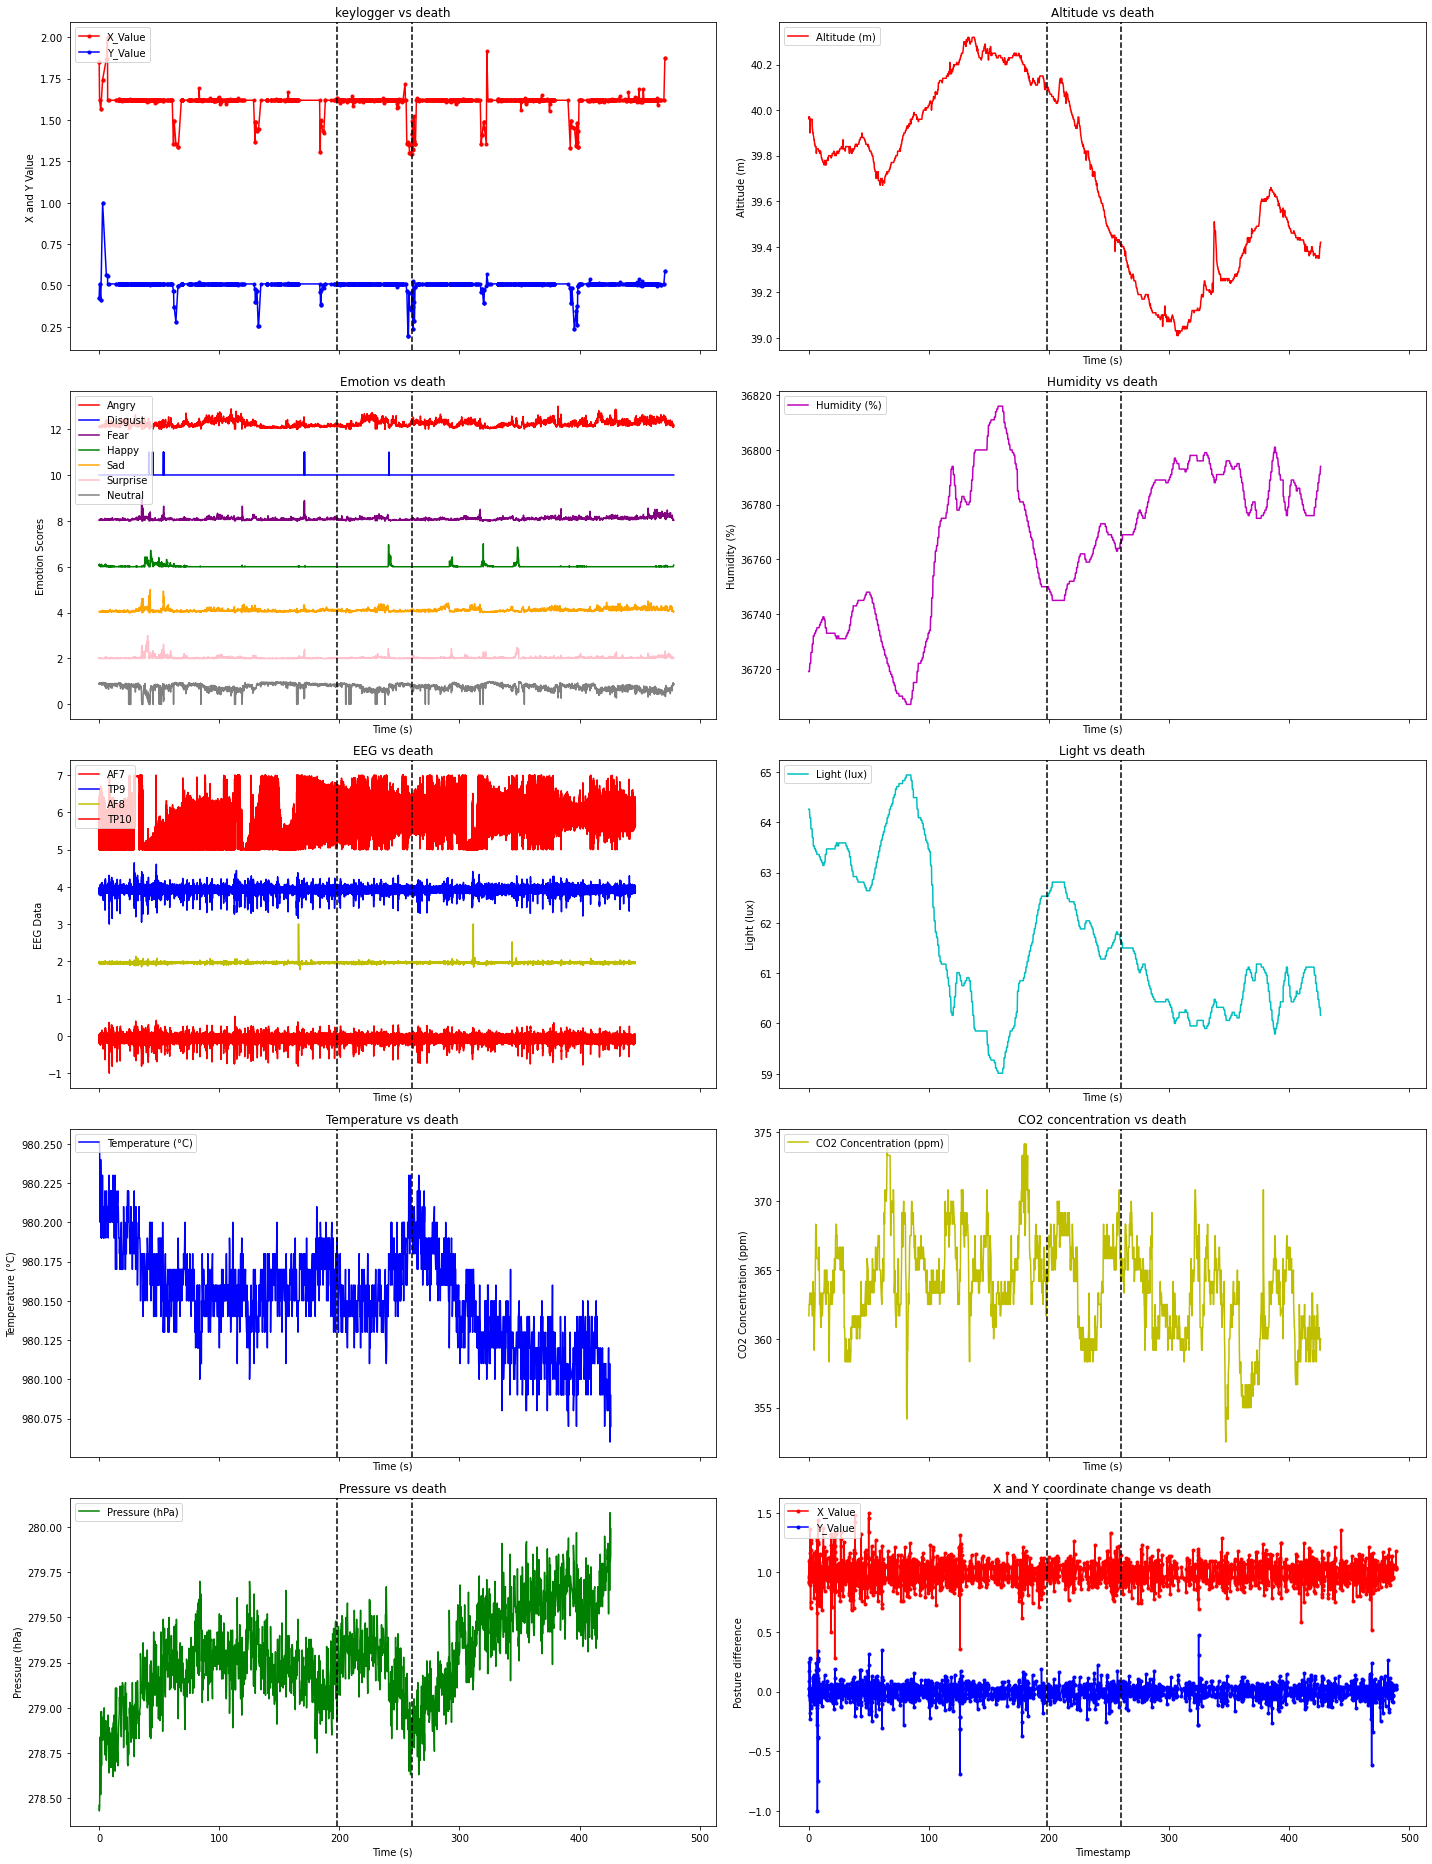

In [32]:
# Overall against death
# Create a figure with two subplots sharing the x-axis
fig, axs = plt.subplots(5, 2, figsize=(20, 26), sharex=True)

# Plot activity data against death on the first subplot
axs[0,0].plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[0,0].plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')
axs[1,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('X and Y Value', color='black')
axs[0,0].legend(loc='upper left')
axs[0,0].set_title('keylogger vs death')

# Plot vertical lines for deaths on the first subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,0].axvline(timestamp, color='black', linestyle='--')

# Plot Emotion data against death on the second subplot
axs[1,0].plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
axs[1,0].plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
axs[1,0].plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
axs[1,0].plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
axs[1,0].plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
axs[1,0].plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
axs[1,0].plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Emotion Scores', color='black')
axs[1,0].legend(loc='upper left')
axs[1,0].set_title("Emotion vs death")

# Plot vertical lines for deaths on the second subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,0].axvline(timestamp, color='black', linestyle='--')

# EEG against death on the third subplot
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
axs[2,0].plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label='AF7')
axs[2,0].plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label='TP9')
axs[2,0].plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label='AF8')
axs[2,0].plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label='TP10')
axs[2,0].set_xlabel('Time (s)')
axs[2,0].set_ylabel('EEG Data', color='black')
axs[2,0].legend(loc='upper left')
axs[2,0].set_title("EEG vs death")

# Plot vertical lines for kills on the third subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,0].axvline(timestamp, color='black', linestyle='--')

# Temperature against death on the forth subplot
axs[3, 0].plot(time_values_in_seconds, temperature_values, 'b-', label='Temperature (°C)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,0].axvline(timestamp, color='black', linestyle='--')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Temperature (°C)')
axs[3, 0].legend(loc='upper left')
axs[3, 0].set_title("Temperature vs death")

# Pressure against death on the fifth subplot
axs[4, 0].plot(time_values_in_seconds, pressure_values, 'g-', label='Pressure (hPa)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[4,0].axvline(timestamp, color='black', linestyle='--')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Pressure (hPa)')
axs[4, 0].legend(loc='upper left')
axs[4, 0].set_title("Pressure vs death")

# Altitude against death on the sixth subplot
axs[0, 1].plot(time_values_in_seconds, altitude_values, 'r-', label='Altitude (m)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,1].axvline(timestamp, color='black', linestyle='--')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Altitude (m)')
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title("Altitude vs death")

# Humidity against death on the seventh subplot
axs[1, 1].plot(time_values_in_seconds, humidity_values, 'm-', label='Humidity (%)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,1].axvline(timestamp, color='black', linestyle='--')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Humidity (%)')
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_title("Humidity vs death")

# Light against death on the eighth subplot
axs[2, 1].plot(time_values_in_seconds, light_values, 'c-', label='Light (lux)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,1].axvline(timestamp, color='black', linestyle='--')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Light (lux)')
axs[2, 1].legend(loc='upper left')
axs[2, 1].set_title("Light vs death")

# CO2 concentration against death on the nineth subplot
axs[3, 1].plot(time_values_in_seconds, co2_values, 'y-', label='CO2 Concentration (ppm)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,1].axvline(timestamp, color='black', linestyle='--')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('CO2 Concentration (ppm)')
axs[3, 1].legend(loc='upper left')
axs[3, 1].set_title("CO2 concentration vs death")

# Posture change against death on the tenth subplot
axs[4, 1].plot(posture['Timestamp'], posture['X Coordinate Difference']/max(abs(posture['X Coordinate Difference']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[4, 1].plot(posture['Timestamp'], posture['Y Coordinate Difference']/max(abs(posture['Y Coordinate Difference'])), marker='.', linestyle='-', color='blue', label='Y_Value')
# Plot vertical lines for kills
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[4, 1].axvline(timestamp, color='black', linestyle='--')
# Customize the plot
axs[4, 1].set_xlabel('Timestamp')
axs[4, 1].set_ylabel('Posture difference')
axs[4, 1].legend(loc='upper left')
axs[4, 1].set_title('X and Y coordinate change vs death')

# Adjust layout and display the plot
fig.tight_layout()
fig.savefig("Overal Death Graph.png")
plt.show()
plt.close(fig)

## 7.3 Overall Death and Kill of Data (Except IMU)

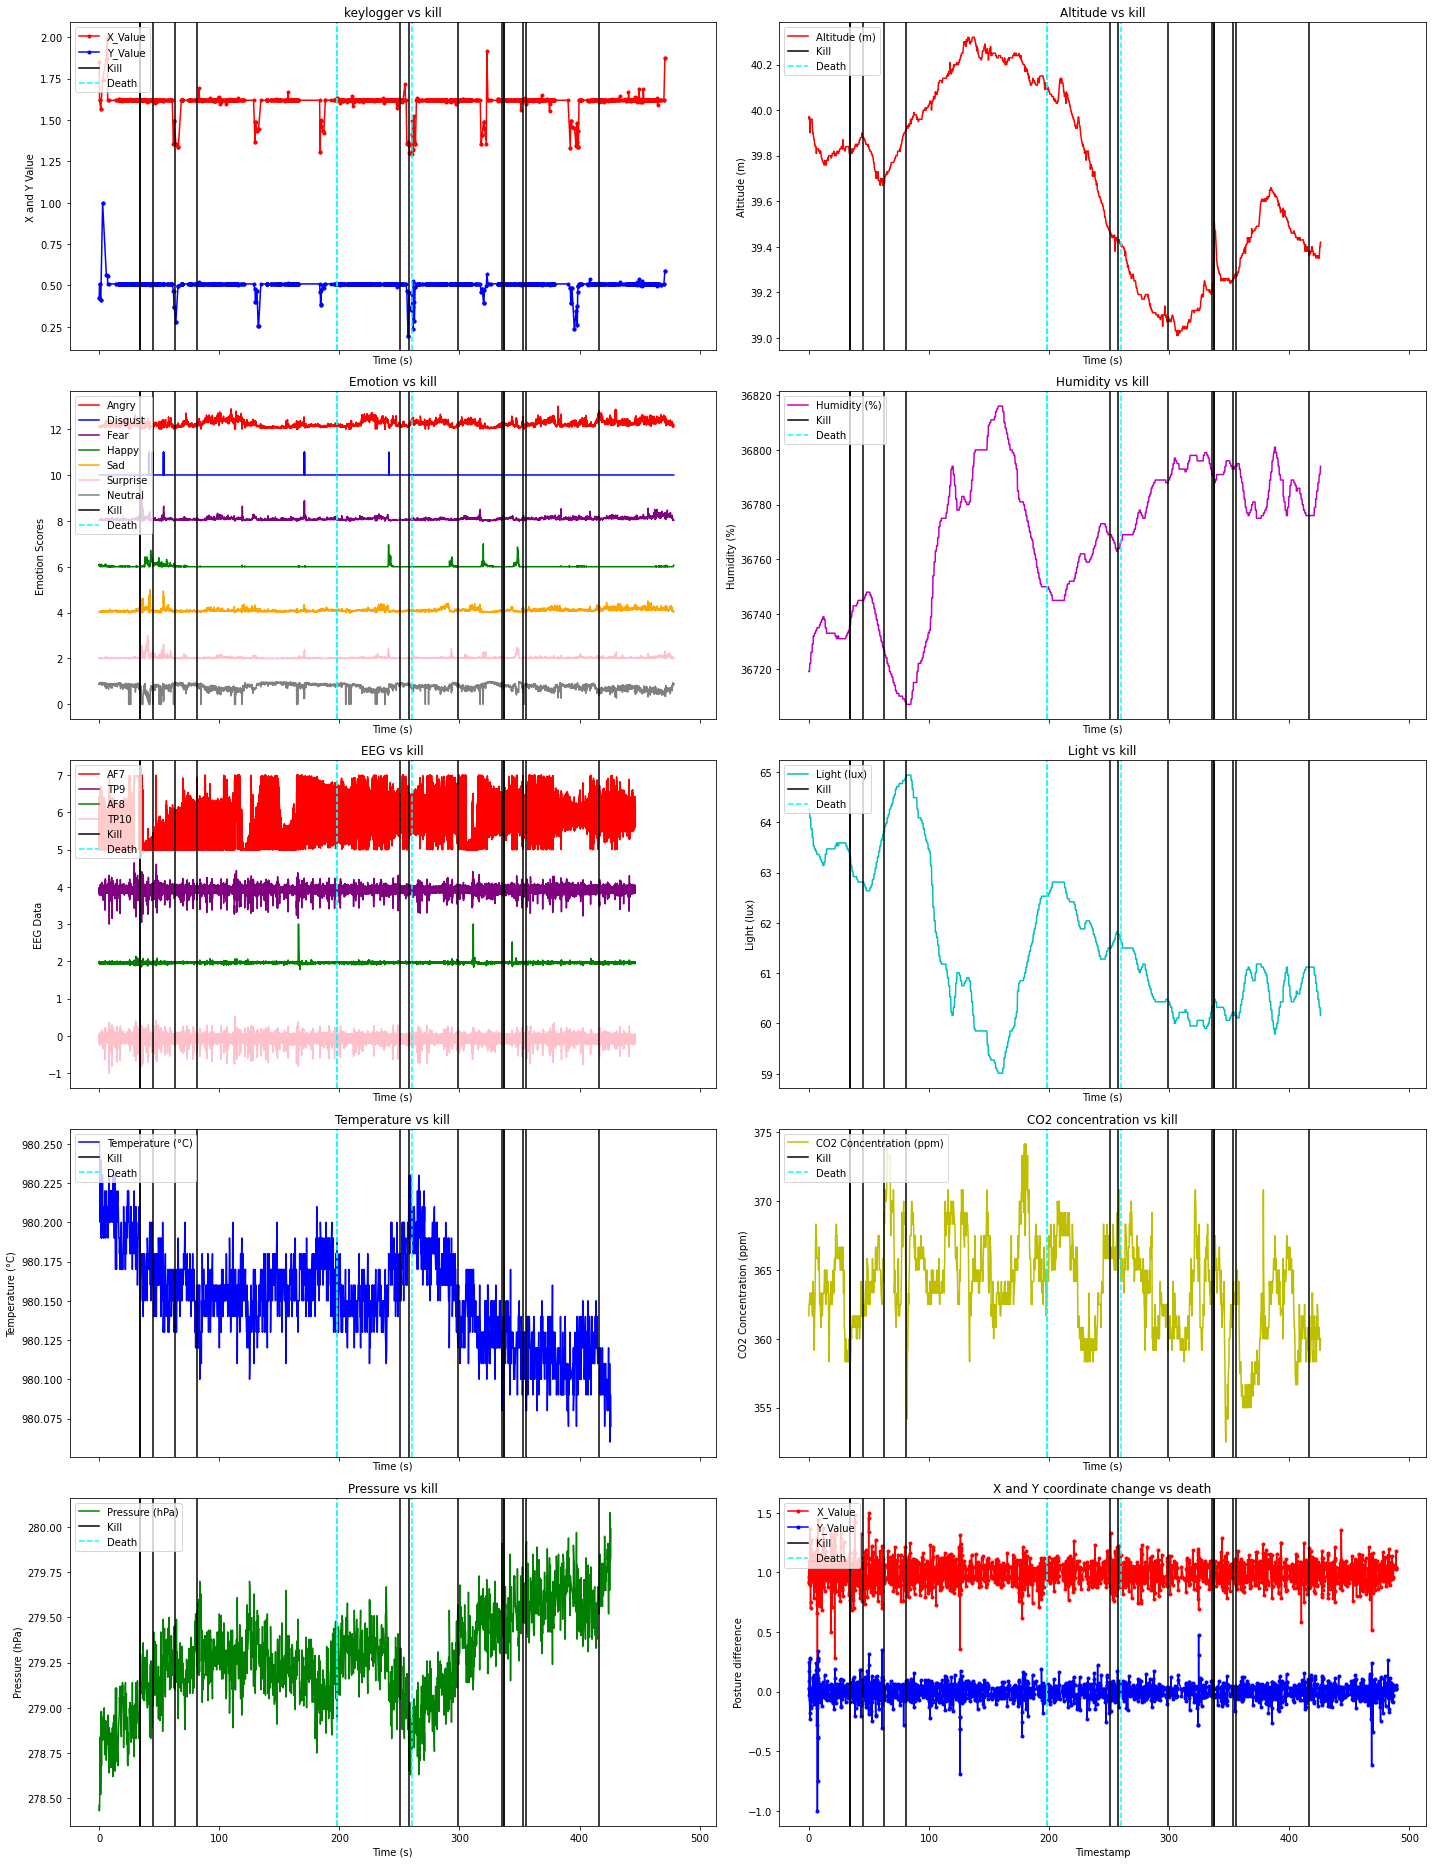

In [33]:
# Overall Graph
# Create a figure with two subplots sharing the x-axis
fig, axs = plt.subplots(5, 2, figsize=(20, 26), sharex=True)
#labels = ['Dead', 'Kill']

# Plot activity data on the first subplot
axs[0,0].plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[0,0].plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')
# Settup Label
axs[0, 0].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[0, 0].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
# Plot vertical lines for kills on the first subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the first subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,0].axvline(timestamp, color='cyan', linestyle='--')
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('X and Y Value', color='black')
axs[0,0].legend(loc='upper left')
axs[0,0].set_title('keylogger vs kill')
        
    
# Plot Emotion data on the second subplot
axs[1,0].plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
axs[1,0].plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
axs[1,0].plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
axs[1,0].plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
axs[1,0].plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
axs[1,0].plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
axs[1,0].plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
# Settup Label
axs[1, 0].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[1, 0].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
# Plot vertical lines for kills on the second subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the second subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,0].axvline(timestamp, color='cyan', linestyle='--')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Emotion Scores', color='black')
axs[1,0].legend(loc='upper left')
axs[1,0].set_title("Emotion vs kill")
        
    
# EEG on the third subplot
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
axs[2,0].plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label='AF7',color = 'red')
axs[2,0].plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4,label='TP9',color='purple')
axs[2,0].plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label='AF8',color='green')
axs[2,0].plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)),label='TP10',color='pink')
# Settup Label
axs[2, 0].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[2, 0].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
# Plot vertical lines for kills on the third subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the third subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,0].axvline(timestamp, color='cyan', linestyle='--')
axs[2,0].set_xlabel('Time (s)')
axs[2,0].set_ylabel('EEG Data', color='black')
axs[2,0].legend(loc='upper left')
axs[2,0].set_title("EEG vs kill")

        
# Temperature on the forth subplot
axs[3, 0].plot(time_values_in_seconds, temperature_values, 'b-', label='Temperature (°C)')
# Settup Label
axs[3, 0].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[3, 0].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the forth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,0].axvline(timestamp, color='cyan', linestyle='--')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Temperature (°C)')
axs[3, 0].legend(loc='upper left')
axs[3, 0].set_title("Temperature vs kill")


# Pressure on the fifth subplot
axs[4, 0].plot(time_values_in_seconds, pressure_values, 'g-', label='Pressure (hPa)')
# Settup Label
axs[4, 0].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[4, 0].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[4,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the fifth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[4,0].axvline(timestamp, color='cyan', linestyle='--')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Pressure (hPa)')
axs[4, 0].legend(loc='upper left')
axs[4, 0].set_title("Pressure vs kill")


# Altitude on the sixth subplot
axs[0, 1].plot(time_values_in_seconds, altitude_values, 'r-', label='Altitude (m)')
# Settup Label
axs[0, 1].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[0, 1].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the sixth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,1].axvline(timestamp, color='cyan', linestyle='--')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Altitude (m)')
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title("Altitude vs kill")


# Humidity on the seventh subplot
axs[1, 1].plot(time_values_in_seconds, humidity_values, 'm-', label='Humidity (%)')
# Settup Label
axs[1, 1].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[1, 1].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the seventh subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,1].axvline(timestamp, color='cyan', linestyle='--')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Humidity (%)')
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_title("Humidity vs kill")


# Light on the eighth subplot
axs[2, 1].plot(time_values_in_seconds, light_values, 'c-', label='Light (lux)')
# Settup Label
axs[2, 1].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[2, 1].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the eighth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,1].axvline(timestamp, color='cyan', linestyle='--')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Light (lux)')
axs[2, 1].legend(loc='upper left')
axs[2, 1].set_title("Light vs kill")


# CO2 concentration on the nineth subplot
axs[3, 1].plot(time_values_in_seconds, co2_values, 'y-', label='CO2 Concentration (ppm)')
# Settup Label
axs[3, 1].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[3, 1].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the nineth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,1].axvline(timestamp, color='cyan', linestyle='--')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('CO2 Concentration (ppm)')
axs[3, 1].legend(loc='upper left')
axs[3, 1].set_title("CO2 concentration vs kill")


# Posture change on the tenth subplot
axs[4, 1].plot(posture['Timestamp'], posture['X Coordinate Difference']/max(abs(posture['X Coordinate Difference']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[4, 1].plot(posture['Timestamp'], posture['Y Coordinate Difference']/max(abs(posture['Y Coordinate Difference'])), marker='.', linestyle='-', color='blue', label='Y_Value')
# Settup Label
axs[4, 1].axvline(kill_timestamps[0], color='black', linestyle='-', label='Kill')
axs[4, 1].axvline(death_timestamps[0], color='cyan', linestyle='--', label='Death')
# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[4, 1].axvline(timestamp, color='black', linestyle='-')
# Plot vertical lines for deaths on the nineth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[4, 1].axvline(timestamp, color='cyan', linestyle='--')
# Customize the plot
axs[4, 1].set_xlabel('Timestamp')
axs[4, 1].set_ylabel('Posture difference')
axs[4, 1].legend(loc='upper left')
axs[4, 1].set_title('X and Y coordinate change vs death')

fig.tight_layout()
plt.show()
fig.savefig("Overal Graph.png")
plt.close(fig)

## 7.4 Overall Kill and Death data (IMU)

Avg. Time between samples:  0.24949939061647555


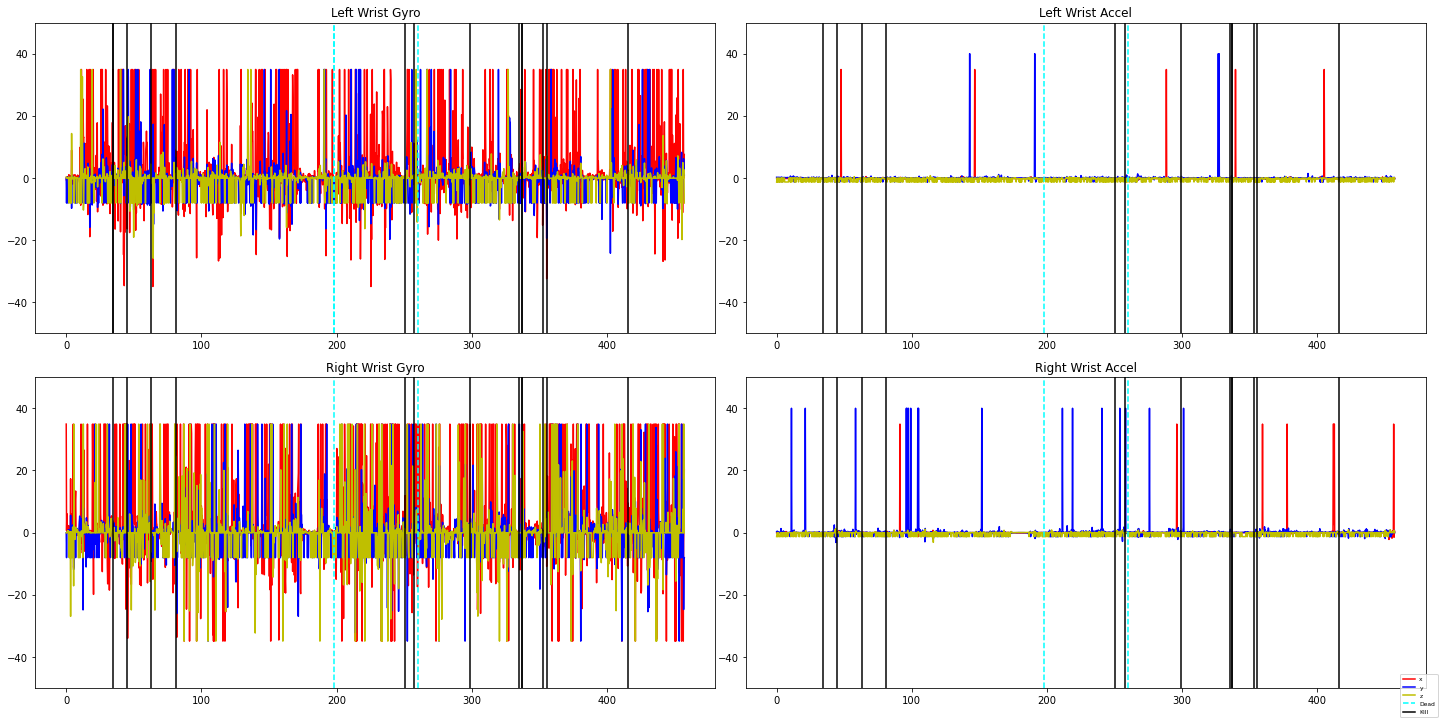

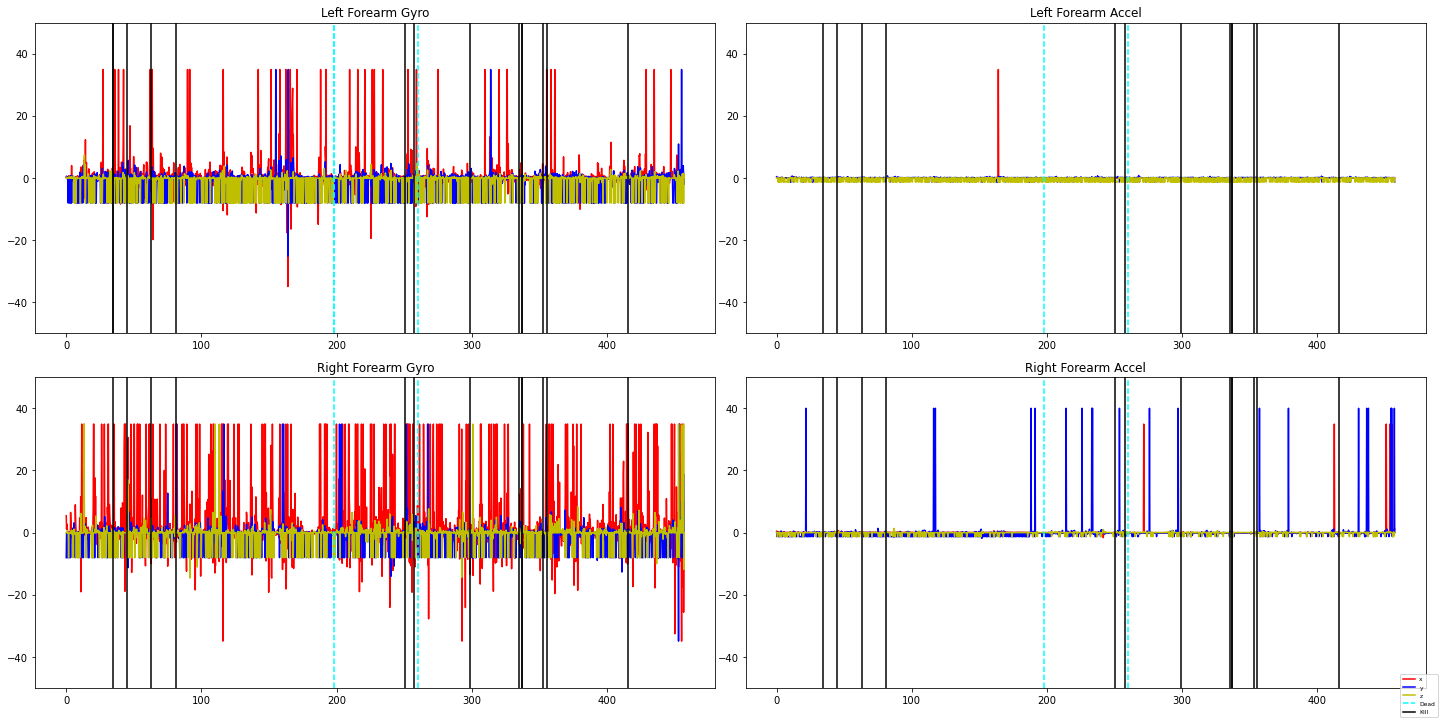

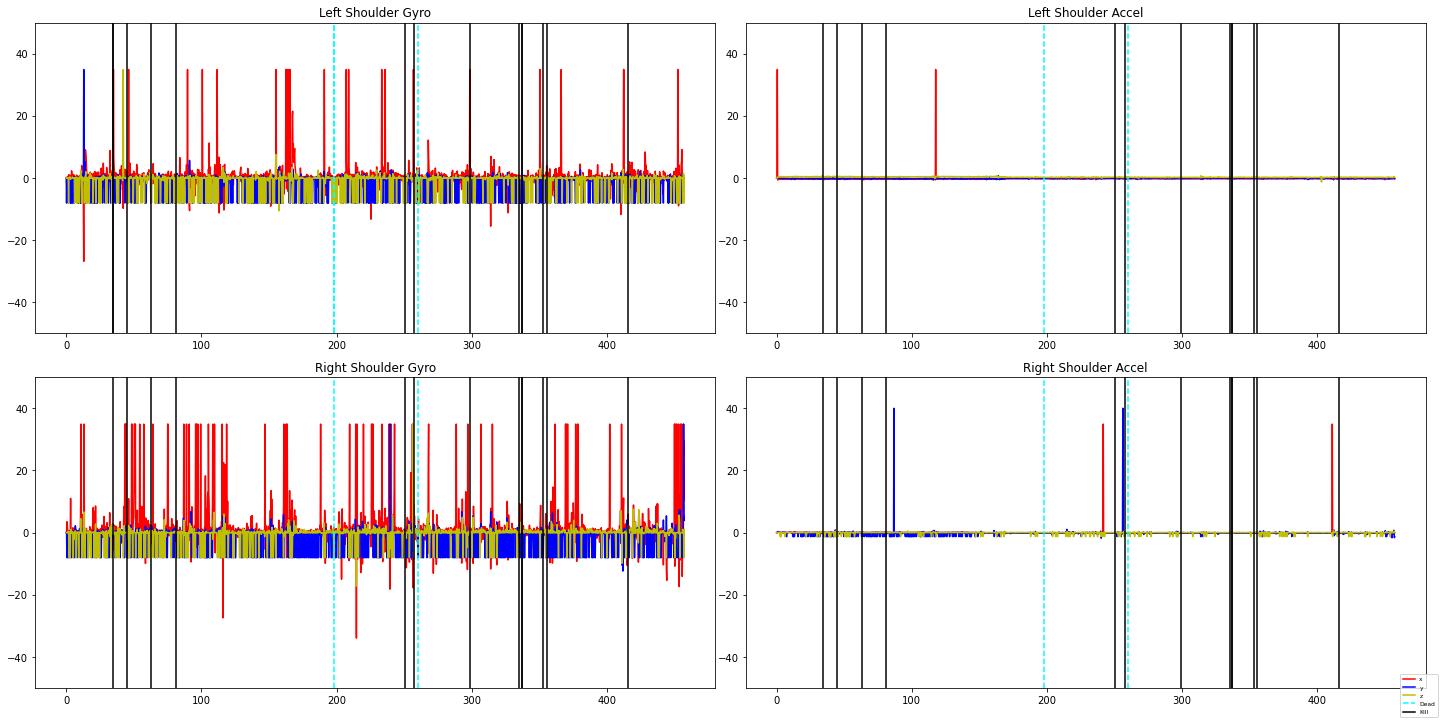

In [34]:
avgtime = 0
for i in range(len(times)-1):
    avgtime += (times[i+1] - times[i]).total_seconds()
avgtime /= (len(times)-1)
print("Avg. Time between samples: ", avgtime)

labels = ['x', 'y', 'z', 'Dead', 'Kill']

# Create three figures, each with four subplots
fig1, axs1 = plt.subplots(2, 2, figsize=(20, 10))
fig2, axs2 = plt.subplots(2, 2, figsize=(20, 10))
fig3, axs3 = plt.subplots(2, 2, figsize=(20, 10))

axs1[0, 0].plot(time_values_in_seconds2, l1_g_data)
axs1[0, 0].set_title("Left Wrist Gyro")
# Settup Label
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs1[0, 0].axvline(timestamp, color='cyan', linestyle='--', label='Death')
        break
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs1[0,0].axvline(timestamp, 0, 2, color='black',linestyle='-', label='Kill')
        break
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs1[0,0].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line    
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs1[0,0].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs1[0, 1].plot(time_values_in_seconds2, l1_a_data)
axs1[0, 1].set_title("Left Wrist Accel")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs1[0,1].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs1[0,1].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs1[1, 0].plot(time_values_in_seconds2, r1_g_data)
axs1[1, 0].set_title("Right Wrist Gyro")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs1[1,0].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs1[1,0].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs1[1, 1].plot(time_values_in_seconds2, r1_a_data)
axs1[1, 1].set_title("Right Wrist Accel")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs1[1,1].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs1[1,1].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs2[0, 0].plot(time_values_in_seconds2, l2_g_data)
axs2[0, 0].set_title("Left Forearm Gyro")
# Settup Label
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs2[0, 0].axvline(timestamp, color='cyan', linestyle='--', label='Death')
        break
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs2[0,0].axvline(timestamp, 0, 2, color='black',linestyle='-', label='Kill')
        break
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs2[0,0].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs2[0,0].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs2[0, 1].plot(time_values_in_seconds2, l2_a_data)
axs2[0, 1].set_title("Left Forearm Accel")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs2[0,1].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs2[0,1].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs2[1, 0].plot(time_values_in_seconds2, r2_g_data)
axs2[1, 0].set_title("Right Forearm Gyro")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs2[1,0].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs2[1,0].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs2[1, 1].plot(time_values_in_seconds2, r2_a_data)
axs2[1, 1].set_title("Right Forearm Accel")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs2[1,1].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs2[1,1].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs3[0, 0].plot(time_values_in_seconds2, l3_g_data)
axs3[0, 0].set_title("Left Shoulder Gyro")
# Settup Label
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs3[0, 0].axvline(timestamp, color='cyan', linestyle='--', label='Death')
        break
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs3[0, 0].axvline(timestamp, 0, 2, color='black',linestyle='-', label='Kill')
        break
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs3[0,0].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs3[0,0].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs3[0, 1].plot(time_values_in_seconds2, l3_a_data)
axs3[0, 1].set_title("Left Shoulder Accel")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs3[0,1].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs3[0,1].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs3[1, 0].plot(time_values_in_seconds2, r3_g_data)
axs3[1, 0].set_title("Right Shoulder Gyro")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs3[1,0].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs3[1,0].axvline(timestamp, 0, 2, color='black',linestyle='-')

axs3[1, 1].plot(time_values_in_seconds2, r3_a_data)
axs3[1, 1].set_title("Right Shoulder Accel")
# Death vertical line
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs3[1,1].axvline(timestamp, color='cyan', linestyle='--')
# Kill vertical line  
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs3[1,1].axvline(timestamp, 0, 2, color='black',linestyle='-')

fig1.legend(labels, loc='lower right', prop={'size': 6})
fig2.legend(labels, loc='lower right', prop={'size': 6})
fig3.legend(labels, loc='lower right', prop={'size': 6})
fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()


plt.setp(axs1, ylim=(-50, 50))
plt.setp(axs2, ylim=(-50, 50))
plt.setp(axs3, ylim=(-50, 50))
fig1.savefig("Wrist.png")
fig2.savefig("Forearm.png")
fig3.savefig("Shoulder.png")
plt.show()
plt.close(fig1)
plt.close(fig2)
plt.close(fig3)

# 8. Interval Graph of Gaze

## 8.1 Kill Interval Graph

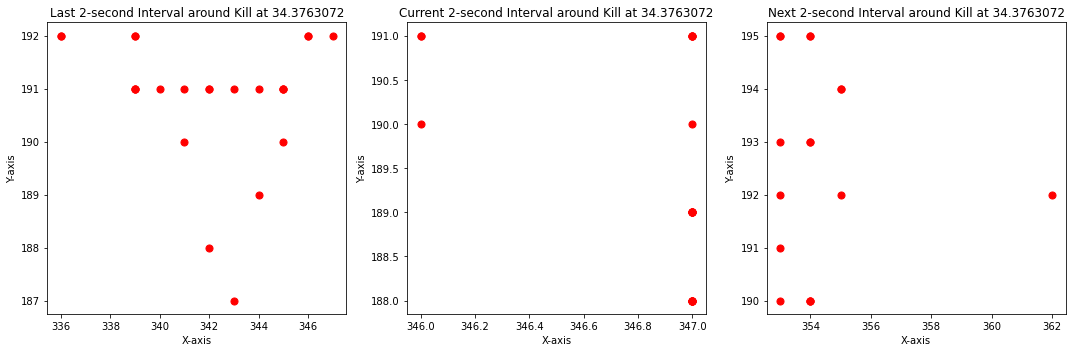

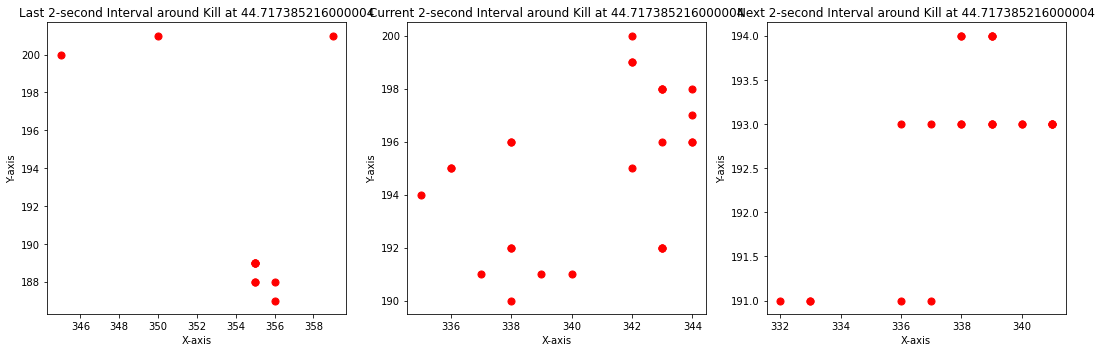

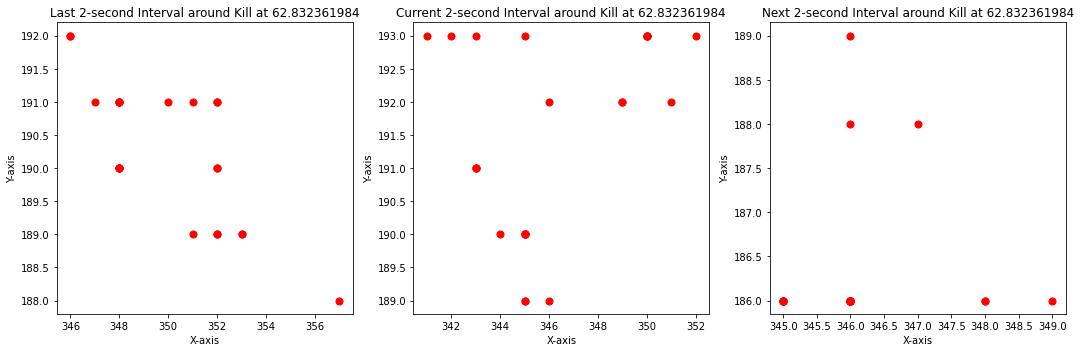

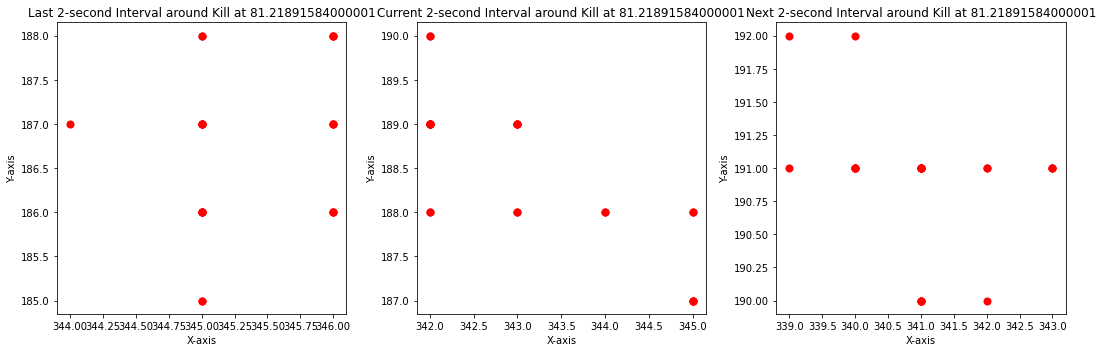

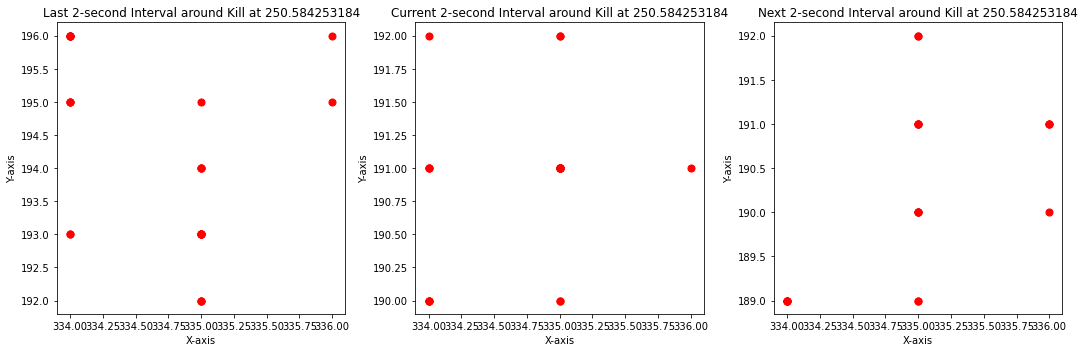

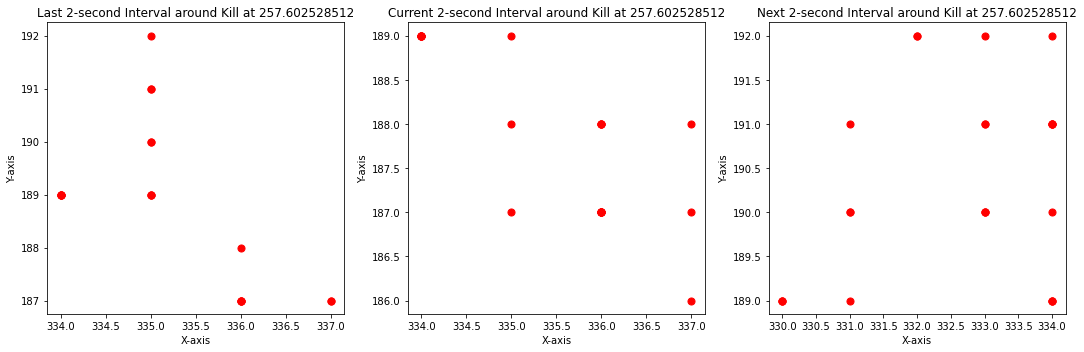

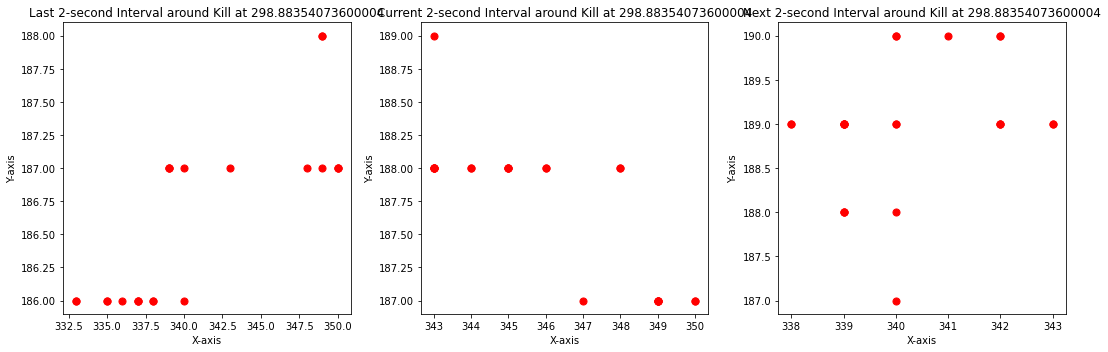

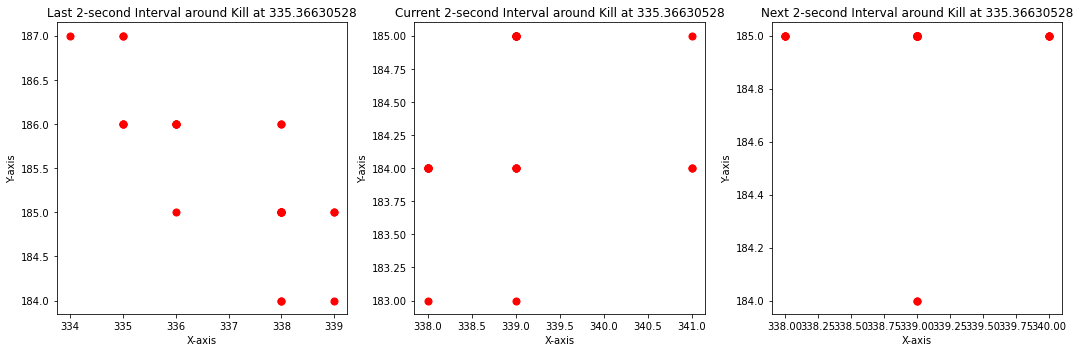

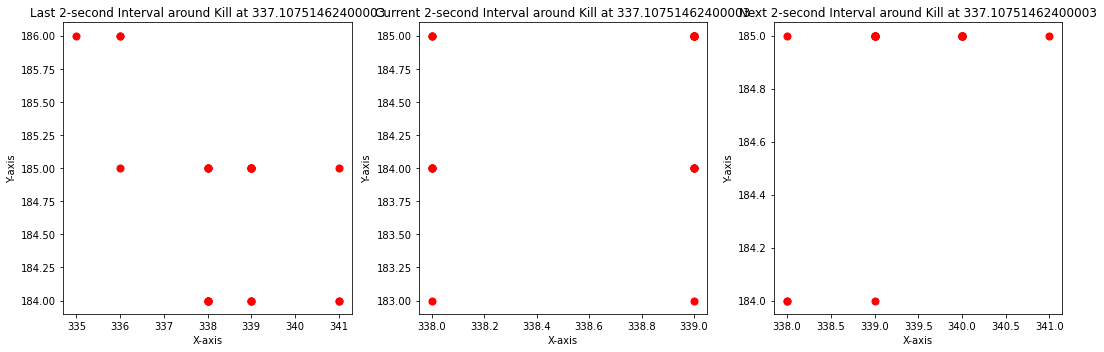

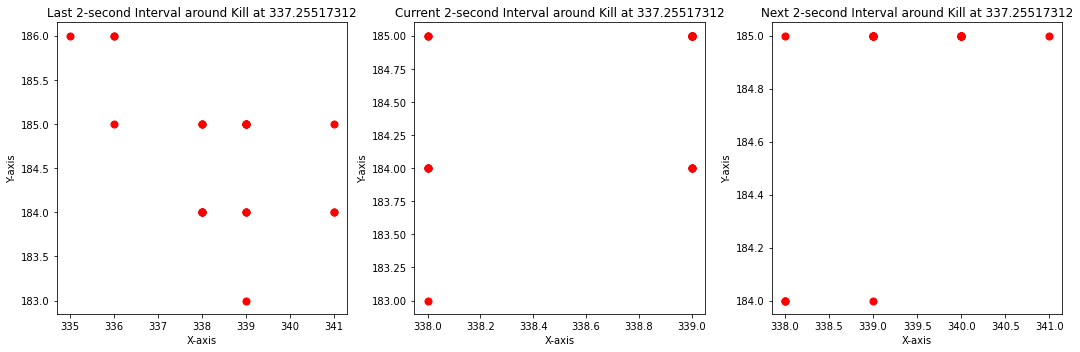

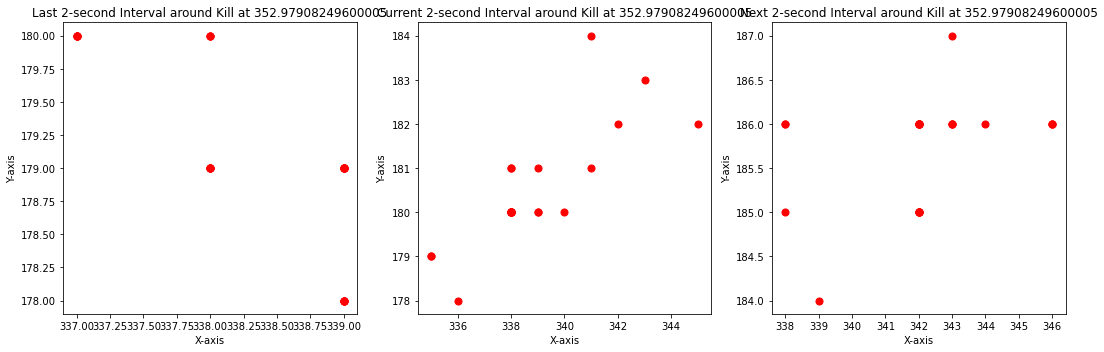

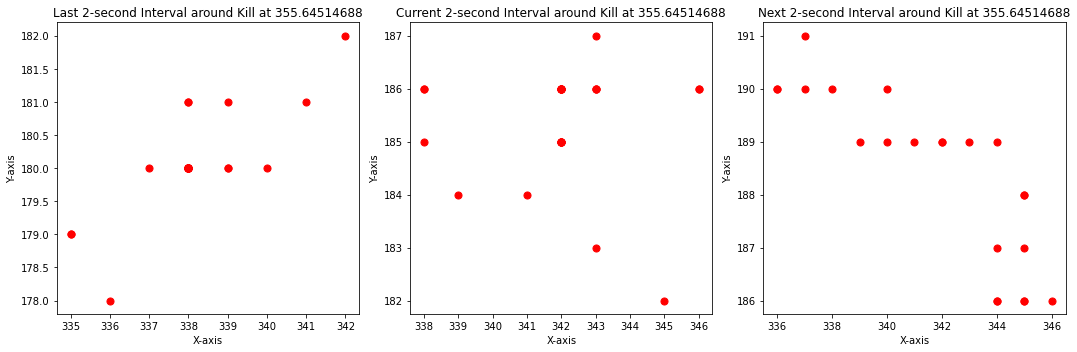

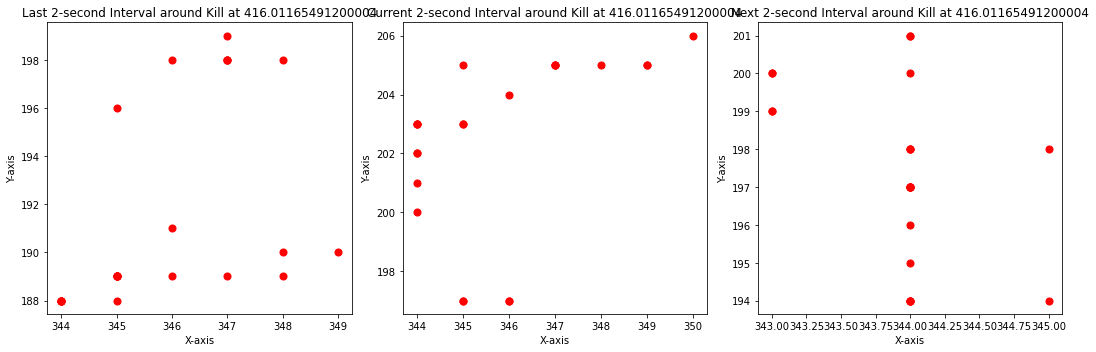

In [35]:
# Iterate through the kill timestamps
for index, (timestamp, kill) in enumerate(zip(kill_df['Timestamp'], kill_df['Kills'])):
    if kill == 1:
        # Define the time ranges for the 2-second intervals
        last_interval_start = timestamp - 1.5
        current_interval_start = timestamp 
        next_interval_start = timestamp + 1.5
        
        # Filter data within the 1-second intervals
        last_interval_data = gaze[(gaze['Timestamp'] >= last_interval_start - 3) & (gaze['Timestamp'] < last_interval_start)]
        current_interval_data = gaze[(gaze['Timestamp'] >= last_interval_start) & (gaze['Timestamp'] <= next_interval_start)]
        next_interval_data = gaze[(gaze['Timestamp'] > next_interval_start) & (gaze['Timestamp'] <= next_interval_start + 3)]
        
        # Filter out rows with 'None' in 'Eye Center'
        last_valid_group = last_interval_data.dropna(subset=['Eye Center'])
        current_valid_group = current_interval_data.dropna(subset=['Eye Center'])
        next_valid_group = next_interval_data.dropna(subset=['Eye Center'])
        
        if not last_valid_group.empty and not current_valid_group.empty and not next_valid_group.empty:
            # Create subplots for the three graphs
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            
            for ax, interval_data, interval_name in zip(axs, [last_valid_group, current_valid_group, next_valid_group], ['Last', 'Current', 'Next']):
                X = np.vstack(interval_data['Eye Center'])
                X = X.astype(float)
                
                # Plot the eye center distribution within the 1-second interval
                ax.scatter(X[:, 0], X[:, 1], s=50)
                ax.set_xlabel('X-axis')
                ax.set_ylabel('Y-axis')
                ax.set_title(f'{interval_name} 2-second Interval around Kill at {timestamp}')
            
            # Save the figure
            plt.tight_layout()
            plt.savefig(f"eye_concentration/kill/eye_center_distribution_around_kill_{timestamp}.png")
            plt.show()  # Display the plot
            plt.close()  # Close the plot to avoid overlapping
            
        else:
            print(f"No data within the 2-second intervals around Kill at {timestamp}.")


## 8.2 Death Interval Graph

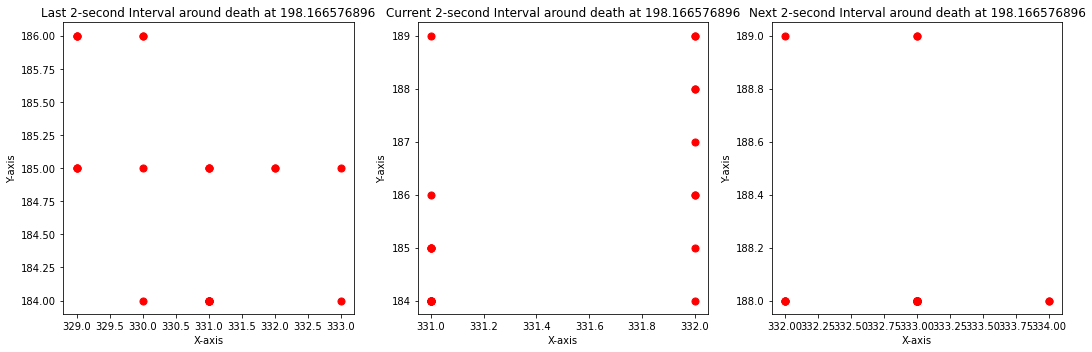

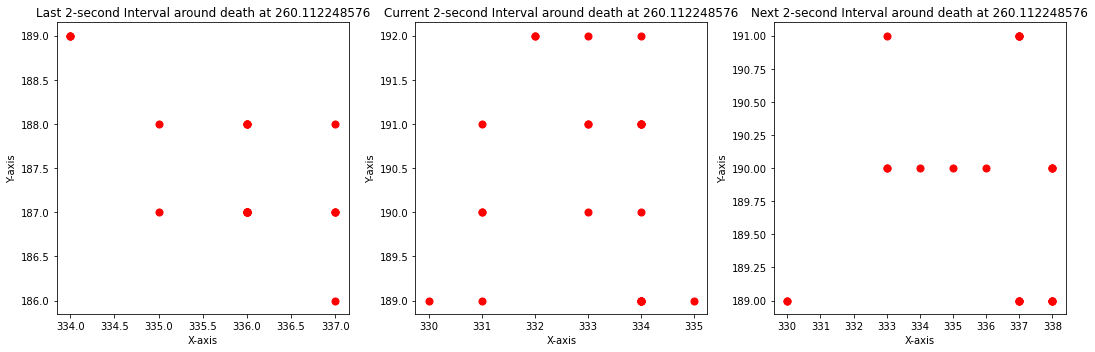

In [36]:
# Iterate through the kill timestamps
for index, (timestamp, death) in enumerate(zip(death_df['Timestamp'], death_df['Death'])):
    if death == 1:
        # Define the time ranges for the 2-second intervals
        last_interval_start = timestamp - 1.5
        current_interval_start = timestamp 
        next_interval_start = timestamp + 1.5
        
        # Filter data within the 1-second intervals
        last_interval_data = gaze[(gaze['Timestamp'] >= last_interval_start - 3.0) & (gaze['Timestamp'] < last_interval_start)]
        current_interval_data = gaze[(gaze['Timestamp'] >= last_interval_start) & (gaze['Timestamp'] <= next_interval_start)]
        next_interval_data = gaze[(gaze['Timestamp'] > next_interval_start) & (gaze['Timestamp'] <= next_interval_start + 3.0)]
        
        # Filter out rows with 'None' in 'Eye Center'
        last_valid_group = last_interval_data.dropna(subset=['Eye Center'])
        current_valid_group = current_interval_data.dropna(subset=['Eye Center'])
        next_valid_group = next_interval_data.dropna(subset=['Eye Center'])
        
        if not last_valid_group.empty and not current_valid_group.empty and not next_valid_group.empty:
            # Create subplots for the three graphs
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            
            for ax, interval_data, interval_name in zip(axs, [last_valid_group, current_valid_group, next_valid_group], ['Last', 'Current', 'Next']):
                X = np.vstack(interval_data['Eye Center'])
                X = X.astype(float)
                
                # Plot the eye center distribution within the 1-second interval
                ax.scatter(X[:, 0], X[:, 1], s=50)
                ax.set_xlabel('X-axis')
                ax.set_ylabel('Y-axis')
                ax.set_title(f'{interval_name} 2-second Interval around death at {timestamp}')
            
            # Save the figure
            plt.tight_layout()
            plt.savefig(f"eye_concentration/death/eye_center_distribution_around_death_{timestamp}.png")
            plt.show()  # Display the plot
            plt.close()  # Close the plot to avoid overlapping
            
        else:
            print(f"No data within the 2-second intervals around death at {timestamp}.")

# 9. Keylogger 

In [37]:
keyboard

,Timestamp,Mouse Position,Input,Type,X_Value,Y_Value
0,0.00,"Point(x=1756, y=603)",Button.left,Mouse Click,1756,603
1,0.10,"Point(x=1756, y=603)",Button.left,Mouse Click,1756,603
2,0.37,"Point(x=1280, y=720)",Key.alt_l,Key Press,1280,720
3,0.41,"Point(x=1280, y=720)",Key.tab,Key Press,1280,720
4,1.33,"Point(x=1169, y=586)",Button.left,Mouse Click,1169,586
...,...,...,...,...,...,...
2847,468.21,"Point(x=1280, y=715)",Key.tab,Key Press,1280,715
2848,470.14,"Point(x=1280, y=720)",Key.alt_l,Key Press,1280,720
2849,470.20,"Point(x=1280, y=720)",Key.tab,Key Press,1280,720
2850,471.02,"Point(x=1803, y=827)",Button.left,Mouse Click,1803,827


In [38]:
kill_timestamps

[34.3763072,
 44.717385216000004,
 62.832361984,
 81.21891584000001,
 250.584253184,
 257.602528512,
 298.88354073600004,
 335.36630528,
 337.10751462400003,
 337.25517312,
 352.97908249600005,
 355.64514688,
 416.01165491200004]

12
7
4
15
3
6
28
33
6
10
11


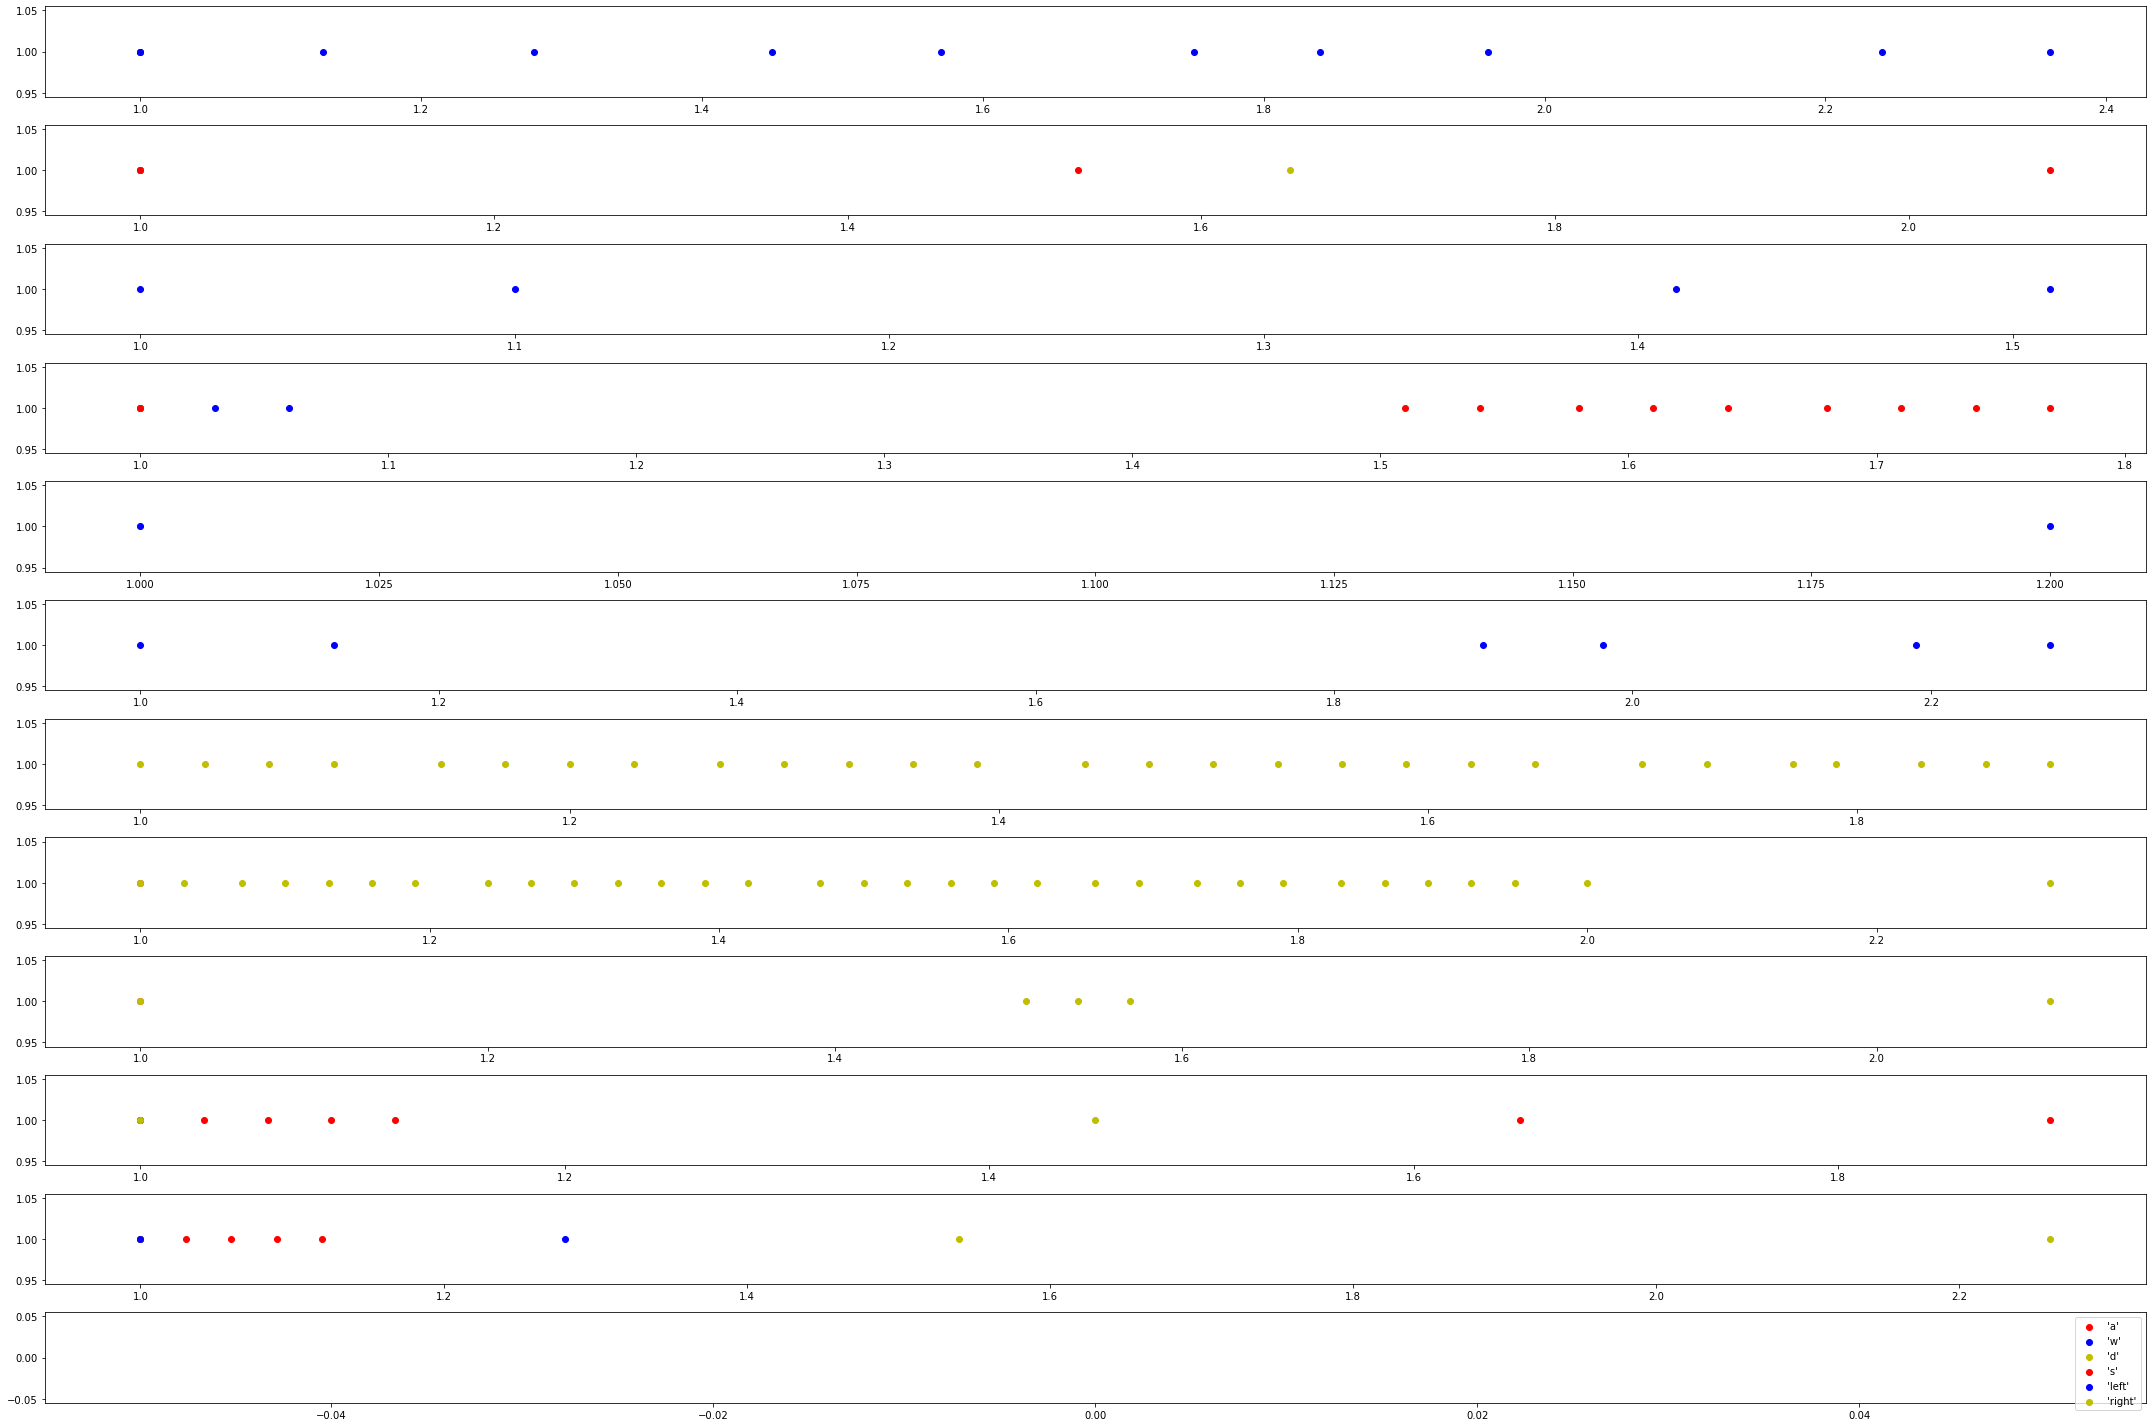

<Figure size 432x288 with 0 Axes>

In [39]:
tolerance = 1
previous_time = 0
row_timestamp = []

row_a = []
row_w = []
row_s = []
row_d = []
row_left = [] 
row_right = []

count = 0

fig = plt.figure(figsize=(30, 20))
gs = fig.add_gridspec(12, 1)  # 6 rows, 2 columns
axs = gs.subplots()
axs = axs.flatten()

previous_time = 0
for time in kill_timestamps:
    if previous_time == 0:
        previous_time  = time
        
    if time != previous_time and time - previous_time <= 2 * tolerance:
        continue
        
    for index, row in keyboard.iterrows():
        if abs(time - row['Timestamp']) <= tolerance:               
            update_row_data(row, row_timestamp, row_a, row_w, row_s, row_d, row_left, row_right)
            
    print(len(row_timestamp))
    row_timestamp = [(x - row_timestamp[0] + 1)for x in row_timestamp]
    
    plot_logger(axs, count, row_timestamp, row_a, row_w, row_s, row_d, row_left, row_right)

    # axs[count].xaxis.set_major_formatter(plt.NullFormatter())

    row_timestamp = []
    row_a = []
    row_w = []
    row_s = []
    row_d = []
    row_left = [] 
    row_right = []

    count += 1   
        
    previous_time = time

row_timestamp = [(x - row_timestamp[0] + 1) for x in row_timestamp]

plot_logger(axs, count, row_timestamp, row_a, row_w, row_s, row_d, row_left, row_right)
axs[count].legend()
plt.tight_layout()

# Show the entire figure with subplots
plt.show()
plt.savefig("keylogger.png")